In [91]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Optional, Union, List
from sklearn.metrics.pairwise import cosine_similarity
from pykalman import KalmanFilter
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import copy
import scipy
from git_code.Chapter3.KalmanFilters import KalmanFilters
from git_code.Chapter3.OutlierDetection import DistanceBasedOutlierDetection
from git_code.Chapter3.DataTransformation import LowPassFilter, PrincipalComponentAnalysis

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [92]:
import os
import sys
from pathlib import Path

# Get the current working directory
current_working_directory = os.getcwd()
print("Current working directory:", current_working_directory)

Current working directory: /Users/aledpro/Desktop/VUa/First_Year/P6


# Read Data

Trial 1

In [93]:
yaoyi_trial_1_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/yaoyi_trial_1_audio_spec.csv')
yaoyi_trial_1_brightness_raw = pd.read_csv('./data/Brightness/yaoyi_trial_1_brightness.csv')
yaoyi_trial_1_audio_amp_raw = pd.read_csv('./data/Audio_Amp/yaoyi_trial_1_audio_amp.csv')
yaoyi_trial_1_acceleration_raw = pd.read_csv('./data/Acceleration/yaoyi_trial_1_acceleration.csv')
yaoyi_trial_1_inclination_raw = pd.read_csv('./data/Inclination/yaoyi_trial_1_inclination.csv')
yaoyi_trial_1_audio_spectrum_raw 

Time (s)  Peak-Frequency
0        0.255078         46.8750
1        0.297745         70.3125
2        0.463538         70.3125
3        0.613441         70.3125
4        0.656107         70.3125
...           ...             ...
21070  909.061287         46.8750
21071  909.103954         46.8750
21072  909.146620         46.8750
21073  909.189287         46.8750
21074  909.231954         46.8750

[21075 rows x 2 columns]

In [94]:
yaoyi_trial_1_brightness_raw

timestamp  BrightnessEV
0      1717743150995      2.873449
1      1717743151057      2.866906
2      1717743151123      2.806646
3      1717743151190      2.847098
4      1717743151257      2.912095
...              ...           ...
13654  1717744061255      3.064837
13655  1717744061321      3.041250
13656  1717744061388      3.025309
13657  1717744061455      3.033302
13658  1717744061521      3.049156

[13659 rows x 2 columns]

In [95]:
kiara_trial_1_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/kiara_trial_1_audio_spec.csv')
kiara_trial_1_brightness_1 = pd.read_csv('./data/Brightness/kiara_trial_1_brightness_1.csv')
kiara_trial_1_brightness_2 = pd.read_csv('./data/Brightness/kiara_trial_1_brightness_2.csv')
kiara_trial_1_brightness_raw = pd.concat([kiara_trial_1_brightness_1, kiara_trial_1_brightness_2])
kiara_trial_1_brightness_raw.reset_index(drop=True, inplace=True)
kiara_trial_1_brightness_raw.to_csv('./data/Brightness/kiara_trial_1_brigtness.csv', index=True)
kiara_trial_1_audio_amp_raw = pd.read_csv('./data/Audio_Amp/kiara_trial_1_audio_amp.csv')
kiara_trial_1_acceleration_raw = pd.read_csv('./data/Acceleration/kiara_trial_1_acceleration.csv')
kiara_trial_1_inclination_raw = pd.read_csv('./data/Inclination/kiara_trial_1_inclination.csv')

In [96]:
kiara_trial_1_brightness_raw

timestamp  BrightnessEV
0      1717741592172      5.741496
1      1717741592197      5.741496
2      1717741592264      5.753519
3      1717741592331      5.759492
4      1717741592397      5.747520
...              ...           ...
16093  1717742870648      6.057717
16094  1717742870715      6.050022
16095  1717742870784      6.050022
16096  1717742870847      6.050022
16097  1717742870914      6.050022

[16098 rows x 2 columns]

In [97]:
esmee_trial_1_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/esmee_trial_1_audio_spec.csv')
esmee_trial_1_brightness_1 = pd.read_csv('./data/Brightness/esmee_trial_1_brightness_1.csv')
esmee_trial_1_brightness_2 = pd.read_csv('./data/Brightness/esmee_trial_1_brightness_2.csv')
esmee_trial_1_brightness_3 = pd.read_csv('./data/Brightness/esmee_trial_1_brightness_3.csv')
esmee_trial_1_brightness_raw = pd.concat([esmee_trial_1_brightness_1, esmee_trial_1_brightness_2, esmee_trial_1_brightness_3])
esmee_trial_1_brightness_raw.reset_index(drop=True, inplace=True)
esmee_trial_1_brightness_raw.to_csv('./data/Brightness/esmee_trial_1_brightness.csv', index=True)
esmee_trial_1_audio_amp_raw = pd.read_csv('./data/Audio_Amp/esmee_trial_1_audio_amp.csv')
esmee_trial_1_acceleration_raw = pd.read_csv('./data/Acceleration/esmee_trial_1_acceleration.csv')
esmee_trial_1_inclination_raw = pd.read_csv('./data/Inclination/esmee_trial_1_inclination.csv')

In [98]:
esmee_trial_1_brightness_raw

timestamp  BrightnessEV
0      1717739946496      2.606777
1      1717739946551      2.614682
2      1717739946617      2.614682
3      1717739946685      2.598828
4      1717739946751      2.590836
...              ...           ...
14065  1717741076270      3.494719
14066  1717741076341      3.673567
14067  1717741076404      3.815181
14068  1717741076470      3.916372
14069  1717741076536      3.968366

[14070 rows x 2 columns]

In [99]:
def convert_timestamps_to_seconds(df, timestamp_column):
    
    df[timestamp_column] = (df[timestamp_column] - df[timestamp_column].min()) / 1000.0
    
    return df

In [100]:
yaoyi_trial_1_brightness = yaoyi_trial_1_brightness_raw.copy(deep=True)
yaoyi_trial_1_brightness = convert_timestamps_to_seconds(yaoyi_trial_1_brightness, 'timestamp')
kiara_trial_1_brightness = kiara_trial_1_brightness_raw.copy(deep=True)
kiara_trial_1_brightness = convert_timestamps_to_seconds(kiara_trial_1_brightness, 'timestamp')
esmee_trial_1_brightness = esmee_trial_1_brightness_raw.copy(deep=True)
esmee_trial_1_brightness = convert_timestamps_to_seconds(esmee_trial_1_brightness, 'timestamp')

Trial 2

In [101]:
yaoyi_trial_2_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/yaoyi_trial_2_audio_spec.csv')
yaoyi_trial_2_brightness_raw = pd.read_csv('./data/Brightness/yaoyi_trial_2_brightness.csv')
yaoyi_trial_2_audio_amp_raw = pd.read_csv('./data/Audio_Amp/yaoyi_trial_2_audio_amp.csv')
yaoyi_trial_2_acceleration_raw = pd.read_csv('./data/Acceleration/yaoyi_trial_2_acceleration.csv')
yaoyi_trial_2_inclination_raw = pd.read_csv('./data/Inclination/yaoyi_trial_2_inclination.csv')

In [102]:
kiara_trial_2_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/kiara_trial_2_audio_spec.csv')
kiara_trial_2_brightness_1 = pd.read_csv('./data/Brightness/kiara_trial_2_brightness_1.csv')
kiara_trial_2_brightness_2 = pd.read_csv('./data/Brightness/kiara_trial_2_brightness_2.csv')
kiara_trial_2_brightness_raw = pd.concat([kiara_trial_2_brightness_1, kiara_trial_2_brightness_2])
kiara_trial_2_brightness_raw.reset_index(drop=True, inplace=True)
kiara_trial_2_brightness_raw.to_csv('./data/Brightness/kiara_trial_2_brigtness.csv', index=True)
kiara_trial_2_audio_amp_raw = pd.read_csv('./data/Audio_Amp/kiara_trial_2_audio_amp.csv')
kiara_trial_2_acceleration_raw = pd.read_csv('./data/Acceleration/kiara_trial_2_acceleration.csv')
kiara_trial_2_inclination_raw = pd.read_csv('./data/Inclination/kiara_trial_2_inclination.csv')

In [103]:
esmee_trial_2_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/esmee_trial_2_audio_spec.csv')
esmee_trial_2_brightness_raw = pd.read_csv('./data/Brightness/esmee_trial_2_brightness.csv')
esmee_trial_2_audio_amp_raw = pd.read_csv('./data/Audio_Amp/esmee_trial_2_audio_amp.csv')
esmee_trial_2_acceleration_raw = pd.read_csv('./data/Acceleration/esmee_trial_2_acceleration.csv')
esmee_trial_2_inclination_raw = pd.read_csv('./data/Inclination/esmee_trial_2_inclination.csv')

In [104]:
yaoyi_trial_2_brightness = yaoyi_trial_2_brightness_raw.copy(deep=True)
yaoyi_trial_2_brightness = convert_timestamps_to_seconds(yaoyi_trial_2_brightness, 'timestamp')

In [105]:
kiara_trial_2_brightness = kiara_trial_2_brightness_raw.copy(deep=True)
kiara_trial_2_brightness = convert_timestamps_to_seconds(kiara_trial_2_brightness, 'timestamp')

In [106]:
esmee_trial_2_brightness = esmee_trial_2_brightness_raw.copy(deep=True)
esmee_trial_2_brightness = convert_timestamps_to_seconds(esmee_trial_2_brightness, 'timestamp')

# **Aggragate for 1s** 

In [107]:
def aggregate_data_multiple_columns(df, timestamp_column, interval, features, trial_num, experimenter):

    df_copy = df.copy()

    df_copy['interval_group'] = (df_copy[timestamp_column] // interval) * interval
    
    aggregation_functions = {col: ['max', 'min', 'median', 'mean', 'std'] for col in features}
    
    aggregated = df_copy.groupby('interval_group').agg(aggregation_functions)
    
    aggregated.columns = ['_'.join(col).strip() for col in aggregated.columns.values]
    
    aggregated.reset_index(inplace=True)
    
    aggregated.rename(columns={'interval_group': 'timestamp'}, inplace=True)
    
    max_time = df[timestamp_column].max()
    last_group = (max_time // interval) * interval
    if max_time > last_group:
        last_group_data = df_copy[df_copy[timestamp_column] > last_group]
        if not last_group_data.empty:
            last_group_stats = last_group_data[features].agg(aggregation_functions).T
            new_columns = {}
            for index, row in last_group_stats.iterrows():
                variable_name = index
                for col in last_group_stats.columns:
                    new_columns[col] = f"{variable_name}_{col}"  # Construct new column name
            last_group_stats.rename(columns=new_columns, inplace=True)
            last_group_stats.drop_duplicates(inplace=True)
            last_group_stats['timestamp'] = max_time
            aggregated = pd.merge(aggregated, last_group_stats, how='outer')
            aggregated['trial'] = trial_num
            aggregated['experimenter'] = experimenter
            
    return aggregated

In [108]:
yaoyi_trial_1_brightness_agg = aggregate_data_multiple_columns(yaoyi_trial_1_brightness, 'timestamp', 1, ['BrightnessEV'], '1', 'Yaoyi')
yaoyi_trial_2_brightness_agg = aggregate_data_multiple_columns(yaoyi_trial_2_brightness, 'timestamp', 1, ['BrightnessEV'], '2', 'Yaoyi')
yaoyi_trial_2_brightness_agg

timestamp  BrightnessEV_max  BrightnessEV_min  BrightnessEV_median  \
0        0.000          1.911855          1.288233             1.443913   
1        1.000          1.870827          1.557137             1.633269   
2        2.000          1.816614          1.476764             1.592241   
3        3.000          1.780545          1.499132             1.571282   
4        4.000          2.184385          1.786619             1.840169   
..         ...               ...               ...                  ...   
713    713.000          3.316994          3.233336             3.254710   
714    714.000          4.072522          3.330477             3.762476   
715    715.000          4.226719          3.451432             4.071113   
716    716.000          3.364396          3.346145             3.353096   
717    716.392          3.364396          3.346145             3.353096   

     BrightnessEV_mean  BrightnessEV_std trial experimenter  
0             1.518760          0.240927     2        Yaoyi  
1             1.654649          0.085028     2        Yaoyi  
2             1.601364          0.093029     2        Yaoyi  
3             1.617590          0.116108     2        Yaoyi  
4             1.903222          0.139069     2        Yaoyi  
..                 ...               ...   ...          ...  
713           3.272730          0.027808     2        Yaoyi  
714           3.730140          0.230926     2        Yaoyi  
715           3.967858          0.252422     2        Yaoyi  
716           3.353767          0.007031     2        Yaoyi  
717           3.353767          0.007031     2        Yaoyi  

[718 rows x 8 columns]

In [109]:
yaoyi_trial_1_audio_amp_agg = aggregate_data_multiple_columns(yaoyi_trial_1_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '1', 'Yaoyi')
yaoyi_trial_2_audio_amp_agg = aggregate_data_multiple_columns(yaoyi_trial_2_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '2', 'Yaoyi')

In [110]:
yaoyi_trial_1_audio_amp_agg = aggregate_data_multiple_columns(yaoyi_trial_1_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '1', 'Yaoyi')
yaoyi_trial_2_audio_amp_agg = aggregate_data_multiple_columns(yaoyi_trial_2_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '2', 'Yaoyi')

In [111]:
yaoyi_trial_2_audio_amp_agg

timestamp  Sound pressure level (dB)_max  Sound pressure level (dB)_min  \
0      0.000000                      -4.800901                     -24.889771   
1      1.000000                      -8.623928                     -17.028175   
2      2.000000                     -10.295810                     -16.871763   
3      3.000000                     -13.216578                     -16.491051   
4      4.000000                     -12.562503                     -16.111604   
..          ...                            ...                            ...   
715  715.000000                     -13.762768                     -20.846932   
716  716.000000                     -12.057986                     -15.807089   
717  717.000000                      -7.227903                     -15.222865   
718  718.000000                      -9.314695                     -14.830136   
719  718.470128                      -9.314695                     -14.830136   

     Sound pressure level (dB)_median  Sound pressure level (dB)_mean  \
0                          -16.416692                      -15.961950   
1                          -13.815021                      -13.087071   
2                          -15.156037                      -14.356600   
3                          -14.407502                      -14.614102   
4                          -14.772753                      -14.721363   
..                                ...                             ...   
715                        -18.375733                      -18.366615   
716                        -14.627188                      -14.242499   
717                        -11.240874                      -11.249674   
718                        -11.902692                      -12.496257   
719                        -11.902692                      -12.496257   

     Sound pressure level (dB)_std trial experimenter  
0                         5.801519     2        Yaoyi  
1                         3.220480     2        Yaoyi  
2                         2.211416     2        Yaoyi  
3                         1.092908     2        Yaoyi  
4                         1.120848     2        Yaoyi  
..                             ...   ...          ...  
715                       2.299273     2        Yaoyi  
716                       1.315506     2        Yaoyi  
717                       2.689500     2        Yaoyi  
718                       2.283174     2        Yaoyi  
719                       2.283174     2        Yaoyi  

[720 rows x 8 columns]

In [112]:
yaoyi_trial_1_acceleration_agg = aggregate_data_multiple_columns(yaoyi_trial_1_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '1', 'Yaoyi')
# yaoyi_trial_1_acceleration_agg = yaoyi_trial_1_acceleration_agg.iloc[:-3]
yaoyi_trial_2_acceleration_agg = aggregate_data_multiple_columns(yaoyi_trial_2_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '2', 'Yaoyi')
# yaoyi_trial_2_acceleration_agg = yaoyi_trial_2_acceleration_agg.iloc[:-3]

In [113]:
yaoyi_trial_1_audio_spectrum_agg = aggregate_data_multiple_columns(yaoyi_trial_1_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '1', 'Yaoyi')
yaoyi_trial_2_audio_spectrum_agg = aggregate_data_multiple_columns(yaoyi_trial_2_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '2', 'Yaoyi')

In [114]:
yaoyi_trial_1_inclination_agg = aggregate_data_multiple_columns(yaoyi_trial_1_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '1', 'Yaoyi')
yaoyi_trial_2_inclination_agg = aggregate_data_multiple_columns(yaoyi_trial_2_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '2', 'Yaoyi')

In [115]:
def correct_sequence(df, column):

    values = df[column].tolist()
    expected_value = values[0]
    
    for i in range(1, len(values)):
        expected_value += 1
        if values[i] != expected_value:
            values[i] = expected_value

    if len(values) > 1 and values[-1] - values[-2] != 1:
        values[-1] = df[column].iloc[-1]
    
    df[column] = values

In [116]:
kiara_trial_1_brightness_agg = aggregate_data_multiple_columns(kiara_trial_1_brightness, 'timestamp', 1, ['BrightnessEV'], '1', 'Kiara')
correct_sequence(kiara_trial_1_brightness_agg, 'timestamp')
# kiara_trial_1_brigtness_agg = kiara_trial_1_brightness_agg.iloc[:-2]
kiara_trial_2_brightness_agg = aggregate_data_multiple_columns(kiara_trial_2_brightness, 'timestamp', 1, ['BrightnessEV'], '2', 'Kiara')
# kiara_trial_2_brigtness_agg = kiara_trial_1_brightness_agg.iloc[:-9]

In [117]:
kiara_trial_1_brightness

timestamp  BrightnessEV
0          0.000      5.741496
1          0.025      5.741496
2          0.092      5.753519
3          0.159      5.759492
4          0.225      5.747520
...          ...           ...
16093   1278.476      6.057717
16094   1278.543      6.050022
16095   1278.612      6.050022
16096   1278.675      6.050022
16097   1278.742      6.050022

[16098 rows x 2 columns]

In [118]:
kiara_trial_1_audio_spectrum_agg = aggregate_data_multiple_columns(kiara_trial_1_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '1', 'Kiara')
# kiara_trial_1_audio_spectrum_agg = kiara_trial_1_audio_spectrum_agg.iloc[:-1]
kiara_trial_2_audio_spectrum_agg = aggregate_data_multiple_columns(kiara_trial_2_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '2', 'Kiara')
kiara_trial_2_audio_spectrum_agg

timestamp  Peak-Frequency_max  Peak-Frequency_min  \
0      0.000000             70.3125              46.875   
1      1.000000             46.8750              46.875   
2      2.000000            164.0625              46.875   
3      3.000000             70.3125              46.875   
4      4.000000             46.8750              46.875   
..          ...                 ...                 ...   
608  608.000000            164.0625              46.875   
609  609.000000            164.0625              46.875   
610  610.000000            164.0625              46.875   
611  611.000000             46.8750              46.875   
612  611.025506             46.8750              46.875   

     Peak-Frequency_median  Peak-Frequency_mean  Peak-Frequency_std trial  \
0                 46.87500            49.804688            8.005430     2   
1                 46.87500            46.875000            0.000000     2   
2                 70.31250            80.502717           46.782270     2   
3                 46.87500            49.932065            8.070708     2   
4                 46.87500            46.875000            0.000000     2   
..                     ...                  ...                 ...   ...   
608              164.06250           118.206522           53.107468     2   
609              164.06250           126.358696           52.758816     2   
610              105.46875           109.375000           52.483742     2   
611               46.87500            46.875000                 NaN     2   
612               46.87500            46.875000                 NaN     2   

    experimenter  
0          Kiara  
1          Kiara  
2          Kiara  
3          Kiara  
4          Kiara  
..           ...  
608        Kiara  
609        Kiara  
610        Kiara  
611        Kiara  
612        Kiara  

[613 rows x 8 columns]

In [119]:
kiara_trial_1_audio_amp_agg = aggregate_data_multiple_columns(kiara_trial_1_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '1', 'Kiara')
kiara_trial_2_audio_amp_agg = aggregate_data_multiple_columns(kiara_trial_2_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '2', 'Kiara')

In [120]:
kiara_trial_1_acceleration_agg = aggregate_data_multiple_columns(kiara_trial_1_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '1', 'Kiara')
kiara_trial_1_acceleration_agg = kiara_trial_1_acceleration_agg.iloc[:-3]
kiara_trial_2_acceleration_agg = aggregate_data_multiple_columns(kiara_trial_2_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '2', 'Kiara')
kiara_trial_2_acceleration_agg = kiara_trial_2_acceleration_agg.iloc[:-3]

In [121]:
kiara_trial_1_acceleration_agg

timestamp  Linear Acceleration x (m/s^2)_max  \
0        0.000000                           0.304890   
1        1.000000                           0.230634   
2        2.000000                           0.683960   
3        3.000000                           0.112060   
4        4.000000                           0.460656   
...           ...                                ...   
1069  1069.000000                           0.084875   
1070  1070.000000                           0.109645   
1071  1071.000000                           0.168884   
1072  1072.000000                           0.100241   
1073  1072.072392                                NaN   

      Linear Acceleration x (m/s^2)_min  Linear Acceleration x (m/s^2)_median  \
0                             -0.397519                             -0.050728   
1                             -0.630368                             -0.097114   
2                             -0.445841                              0.023292   
3                             -0.402406                             -0.050409   
4                             -0.798082                              0.044026   
...                                 ...                                   ...   
1069                          -0.346860                             -0.026107   
1070                          -0.133530                             -0.002028   
1071                          -0.155156                             -0.040589   
1072                          -0.057954                              0.024437   
1073                                NaN                                   NaN   

      Linear Acceleration x (m/s^2)_mean  Linear Acceleration x (m/s^2)_std  \
0                              -0.058900                           0.122496   
1                              -0.093954                           0.177388   
2                               0.020294                           0.272748   
3                              -0.078404                           0.124374   
4                              -0.011428                           0.257938   
...                                  ...                                ...   
1069                           -0.051634                           0.092228   
1070                           -0.011437                           0.063225   
1071                           -0.021603                           0.079437   
1072                            0.032855                           0.053407   
1073                                 NaN                                NaN   

      Linear Acceleration y (m/s^2)_max  Linear Acceleration y (m/s^2)_min  \
0                              0.005907                          -0.390533   
1                              0.099924                          -0.688262   
2                              0.597810                          -1.206123   
3                              0.253684                          -0.533109   
4                              0.590465                          -0.751517   
...                                 ...                                ...   
1069                          -0.336250                          -1.109461   
1070                          -0.414399                          -0.610422   
1071                          -0.269274                          -0.619673   
1072                          -0.338814                          -0.456424   
1073                                NaN                                NaN   

      Linear Acceleration y (m/s^2)_median  \
0                                -0.216014   
1                                -0.182620   
2                                -0.185127   
3                                -0.130360   
4                                -0.209452   
...                                    ...   
1069                             -0.576485   
1070                             -0.531349   
1071                             -0.455079   
1072            

In [122]:
kiara_trial_1_inclination_agg = aggregate_data_multiple_columns(kiara_trial_1_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '1', 'Kiara')
kiara_trial_2_inclination_agg = aggregate_data_multiple_columns(kiara_trial_2_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '2', 'Kiara')

In [123]:
esmee_trial_1_brightness_agg = aggregate_data_multiple_columns(esmee_trial_1_brightness, 'timestamp', 1, ['BrightnessEV'], '1', 'Esmee')
correct_sequence(esmee_trial_1_brightness_agg, 'timestamp')
# esmee_trial_1_brightness_agg = esmee_trial_1_brightness_agg.iloc[:-2]
esmee_trial_2_brightness_agg = aggregate_data_multiple_columns(esmee_trial_2_brightness, 'timestamp', 1, ['BrightnessEV'], '2', 'Esmee')

In [124]:
esmee_trial_1_audio_spectrum_agg = aggregate_data_multiple_columns(esmee_trial_1_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '1', 'Esmee')
# esmee_trial_1_audio_spectrum_agg = esmee_trial_1_audio_spectrum_agg.iloc[:-1]
esmee_trial_2_audio_spectrum_agg = aggregate_data_multiple_columns(esmee_trial_2_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '2', 'Esmee')

In [125]:
esmee_trial_1_audio_amp_agg = aggregate_data_multiple_columns(esmee_trial_1_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '1', 'Esmee')
esmee_trial_2_audio_amp_agg = aggregate_data_multiple_columns(esmee_trial_2_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '2', 'Esmee')

In [126]:
esmee_trial_1_acceleration_agg = aggregate_data_multiple_columns(esmee_trial_1_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '1', 'Esmee')
esmee_trial_1_acceleration_agg = esmee_trial_1_acceleration_agg.iloc[:-3]
esmee_trial_2_acceleration_agg = aggregate_data_multiple_columns(esmee_trial_2_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '2', 'Esmee')
esmee_trial_2_acceleration_agg = esmee_trial_2_acceleration_agg.iloc[:-3]

In [127]:
esmee_trial_1_inclination_agg = aggregate_data_multiple_columns(esmee_trial_1_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '1', 'Esmee')
esmee_trial_2_inclination_agg = aggregate_data_multiple_columns(esmee_trial_2_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '2', 'Esmee')

In [128]:
def merge_pd_horizontally(pd_list, key_cols=['timestamp', 'trial', 'experimenter']):
    
    pd_list_copy = [df.copy() for df in pd_list]
    max_timestamp_col = max(pd_list_copy, key=lambda df: df['timestamp'].max())['timestamp']

    for df in pd_list_copy:
        if df['timestamp'] is not max_timestamp_col:
            df.drop(columns=['timestamp'], inplace=True)

    merged_df = pd.concat(pd_list_copy, axis=1, join='outer')
    merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
    merged_df[['trial', 'experimenter']] = merged_df[['trial', 'experimenter']].ffill()

    return merged_df

In [129]:
yaoyi_trial_1_merged = merge_pd_horizontally([yaoyi_trial_1_brightness_agg, yaoyi_trial_1_audio_spectrum_agg, yaoyi_trial_1_audio_amp_agg, yaoyi_trial_1_acceleration_agg, yaoyi_trial_1_inclination_agg])

In [130]:
kiara_trial_1_merged = merge_pd_horizontally([kiara_trial_1_brightness_agg, kiara_trial_1_audio_spectrum_agg, kiara_trial_1_audio_amp_agg, kiara_trial_1_acceleration_agg, kiara_trial_1_inclination_agg])

In [131]:
esmee_trial_1_merged = merge_pd_horizontally([esmee_trial_1_brightness_agg, esmee_trial_1_audio_spectrum_agg, esmee_trial_1_audio_amp_agg, esmee_trial_1_acceleration_agg, esmee_trial_1_inclination_agg])

In [132]:
kiara_trial_2_merged = merge_pd_horizontally([kiara_trial_2_brightness_agg, kiara_trial_2_audio_spectrum_agg, kiara_trial_2_audio_amp_agg, kiara_trial_2_acceleration_agg, kiara_trial_2_inclination_agg])

In [133]:
yaoyi_trial_2_merged = merge_pd_horizontally([yaoyi_trial_2_brightness_agg, yaoyi_trial_2_audio_spectrum_agg, yaoyi_trial_2_audio_amp_agg ,yaoyi_trial_2_acceleration_agg, yaoyi_trial_2_inclination_agg])

In [134]:
esmee_trial_2_merged = merge_pd_horizontally([esmee_trial_2_brightness_agg, esmee_trial_2_audio_spectrum_agg, esmee_trial_2_audio_amp_agg, esmee_trial_2_acceleration_agg, esmee_trial_2_inclination_agg])

In [135]:
# Read and Merge Heart Rate

In [136]:
# suffixes_to_drop = ['_max', '_min', '_std', '_median']
# columns_to_drop = [col for col in yaoyi_trial_1_merged.columns if any(col.endswith(suffix) for suffix in suffixes_to_drop)]
# yaoyi_trial_1_merged.drop(columns=columns_to_drop, inplace=True)
# kiara_trial_1_merged.drop(columns=columns_to_drop, inplace=True)
# esmee_trial_1_merged.drop(columns=columns_to_drop, inplace=True)
# yaoyi_trial_2_merged.drop(columns=columns_to_drop, inplace=True)
# kiara_trial_2_merged.drop(columns=columns_to_drop, inplace=True)
# esmee_trial_2_merged.drop(columns=columns_to_drop, inplace=True)

In [137]:
# yaoyi_trial_1_merged.to_csv('yaoyi_trial_1_merged.csv', index=False)
# yaoyi_trial_2_merged.to_csv('yaoyi_trial_2_merged.csv', index=False)
# kiara_trial_2_merged.to_csv('kiara_trial_2_merged.csv', index=False)
# kiara_trial_1_merged.to_csv('kiara_trial_1_merged.csv', index=False)
# esmee_trial_1_merged.to_csv('esmee_trial_1_merged.csv', index=False)
# esmee_trial_2_merged.to_csv('esmee_trial_2_merged.csv', index=False)

In [138]:
yaoyi_trial_1_heart_rate = pd.read_csv('./data/yaoyi_trial_1_merged_heart.csv')
yaoyi_trial_2_heart_rate = pd.read_csv('./data/yaoyi_trial_2_merged_heart.csv')
kiara_trial_1_heart_rate = pd.read_csv('./data/kiara_trial_1_merged_heart.csv')
kiara_trial_2_heart_rate = pd.read_csv('./data/kiara_trial_2_merged_heart.csv')
esmee_trial_1_heart_rate = pd.read_csv('./data/esmee_trial_1_merged_heart.csv')
esmee_trial_2_heart_rate = pd.read_csv('./data/esmee_trial_2_merged_heart.csv')

def merge_heart_rate(df_merged, df_heartrate):
    
    columns_to_drop = ['BrightnessEV_mean', 'trial', 'experimenter', 'Peak-Frequency_mean', 
                   'Sound pressure level (dB)_mean', 'Linear Acceleration x (m/s^2)_mean', 
                   'Linear Acceleration y (m/s^2)_mean', 'Linear Acceleration z (m/s^2)_mean', 
                   'Absolute acceleration (m/s^2)_mean', 'Inclination (deg)_mean', 
                   'Rotation (deg)_mean', 'Peak-Frequency_norm', 'Sound-pressure-level_norm', 
                   'Linear-Acceleration-norm']
    
    df_heartrate.drop(columns=columns_to_drop, inplace=True)
    merged_df = df_merged.merge(df_heartrate, on='timestamp', how='inner')

    return merged_df

yaoyi_trial_1_merged = merge_heart_rate(yaoyi_trial_1_merged, yaoyi_trial_1_heart_rate)
yaoyi_trial_2_merged = merge_heart_rate(yaoyi_trial_2_merged, yaoyi_trial_2_heart_rate)
kiara_trial_1_merged = merge_heart_rate(kiara_trial_1_merged, kiara_trial_1_heart_rate)
kiara_trial_2_merged = merge_heart_rate(kiara_trial_2_merged, kiara_trial_2_heart_rate)
esmee_trial_1_merged = merge_heart_rate(esmee_trial_1_merged, esmee_trial_1_heart_rate)
esmee_trial_2_merged = merge_heart_rate(esmee_trial_2_merged, esmee_trial_2_heart_rate)

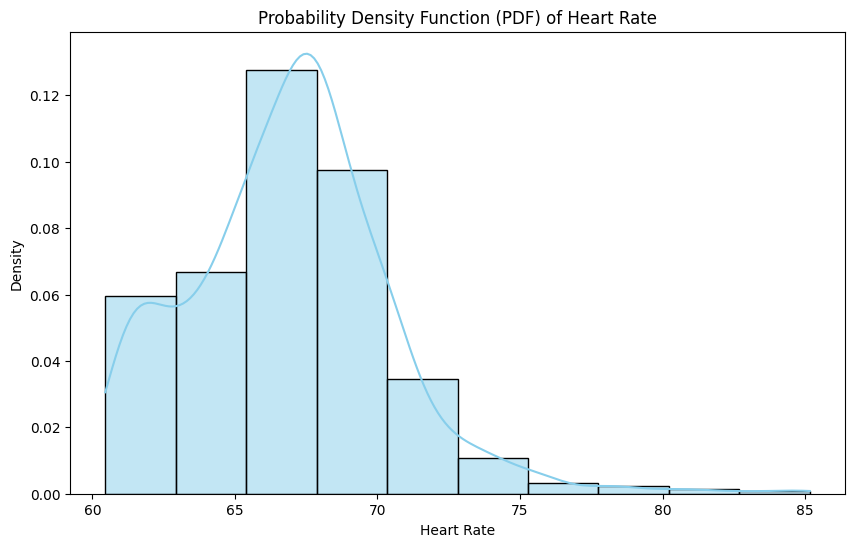

In [139]:
plt.figure(figsize=(10, 6))
sns.histplot(esmee_trial_2_merged['heart_rate'], kde=True, stat='density', bins=10, color='skyblue')
plt.title('Probability Density Function (PDF) of Heart Rate')
plt.xlabel('Heart Rate')
plt.ylabel('Density')
plt.show()

In [140]:
final_merged = pd.concat([yaoyi_trial_1_merged, yaoyi_trial_2_merged, kiara_trial_1_merged, kiara_trial_2_merged,
                         esmee_trial_1_merged, esmee_trial_2_merged], axis=0).reset_index(drop=True)

# Plots

****

In [141]:
def plot_boxplot(df, sensor_to_be_plotted):

    df = pd.DataFrame(df)
    custom_palette = sns.color_palette("husl", len(df['experimenter'].unique()))

    plt.figure(figsize=(20, 8))
    sns.boxplot(data=df, x='trial', y=sensor_to_be_plotted, hue='experimenter', dodge=0.8, palette=custom_palette)
    plt.title(f'Box plot of {sensor_to_be_plotted} grouped by trial and experimenter')
    plt.xlabel('Trial')
    plt.ylabel(f'{sensor_to_be_plotted}')
    plt.legend(title='Experimenter')
    plt.show()

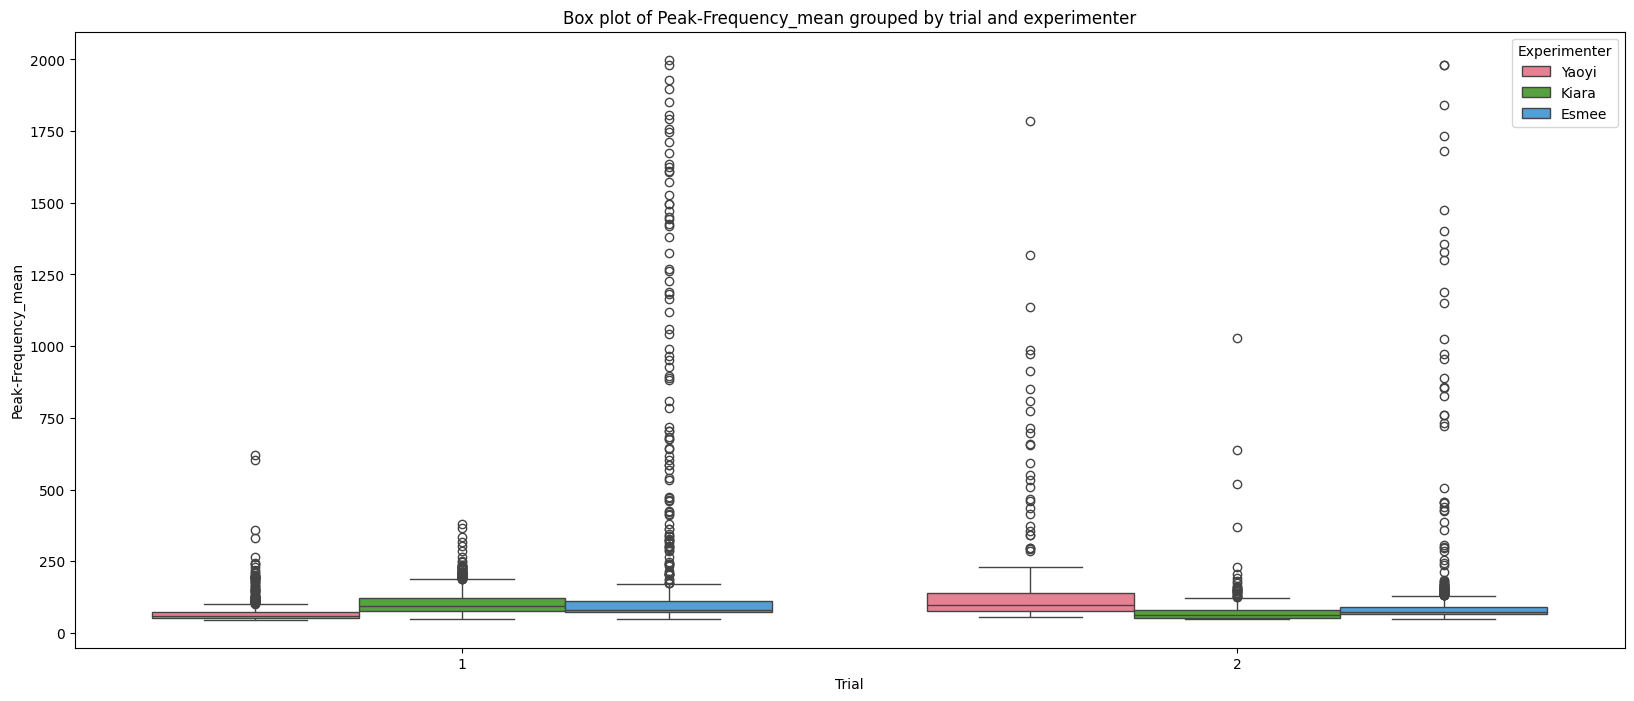

In [142]:
plot_boxplot(final_merged, 'Peak-Frequency_mean')

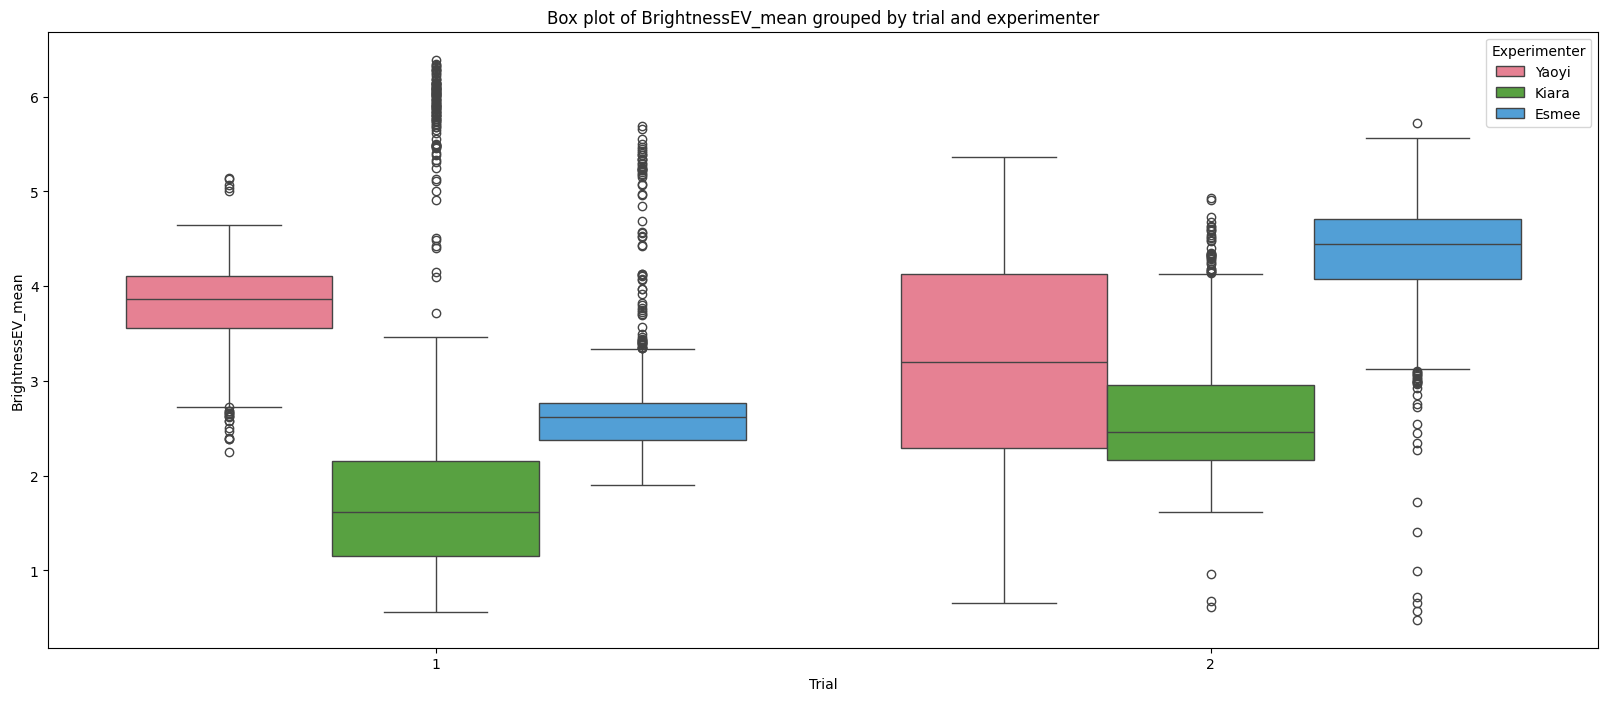

In [143]:
plot_boxplot(final_merged, 'BrightnessEV_mean')

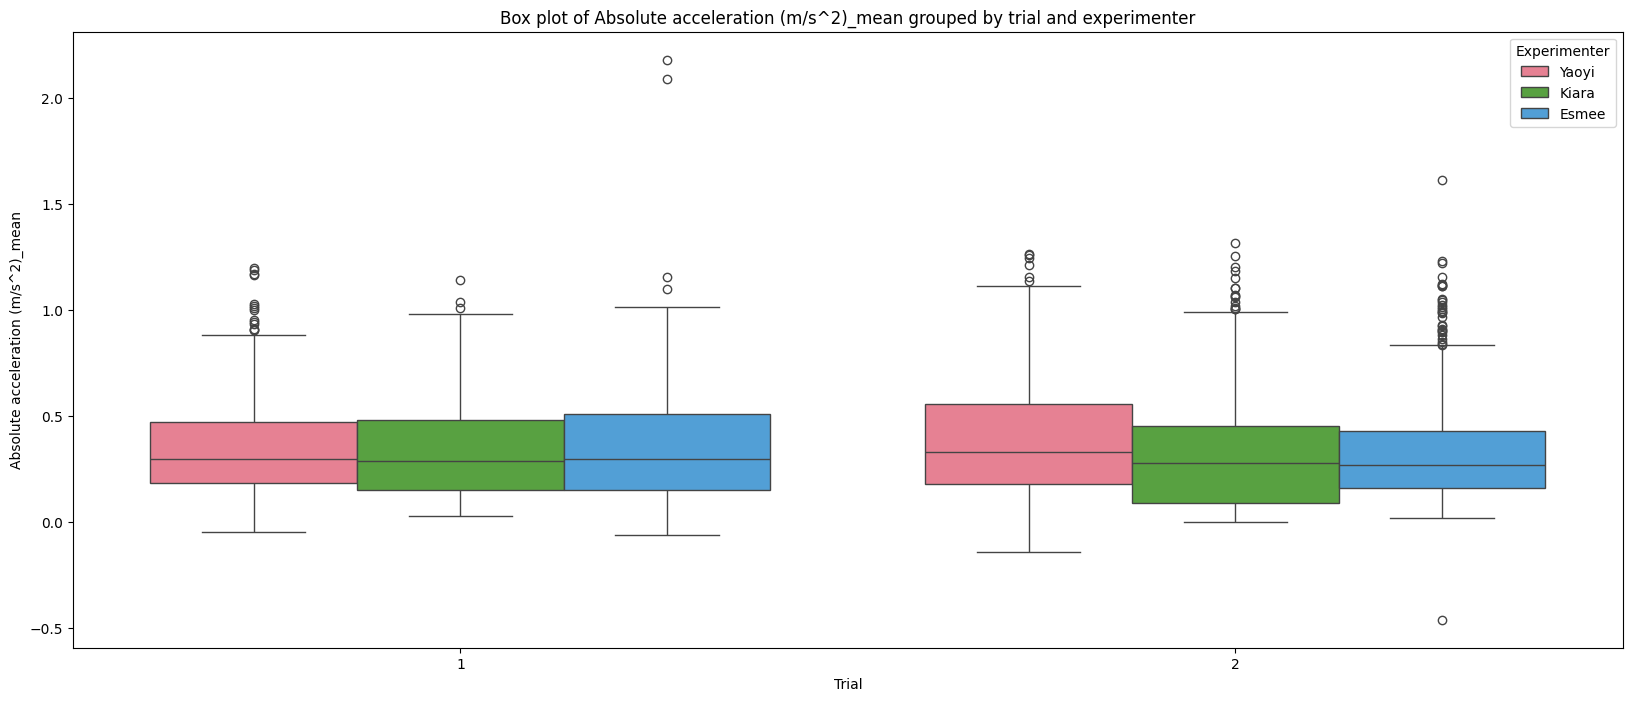

In [144]:
plot_boxplot(final_merged, 'Absolute acceleration (m/s^2)_mean')

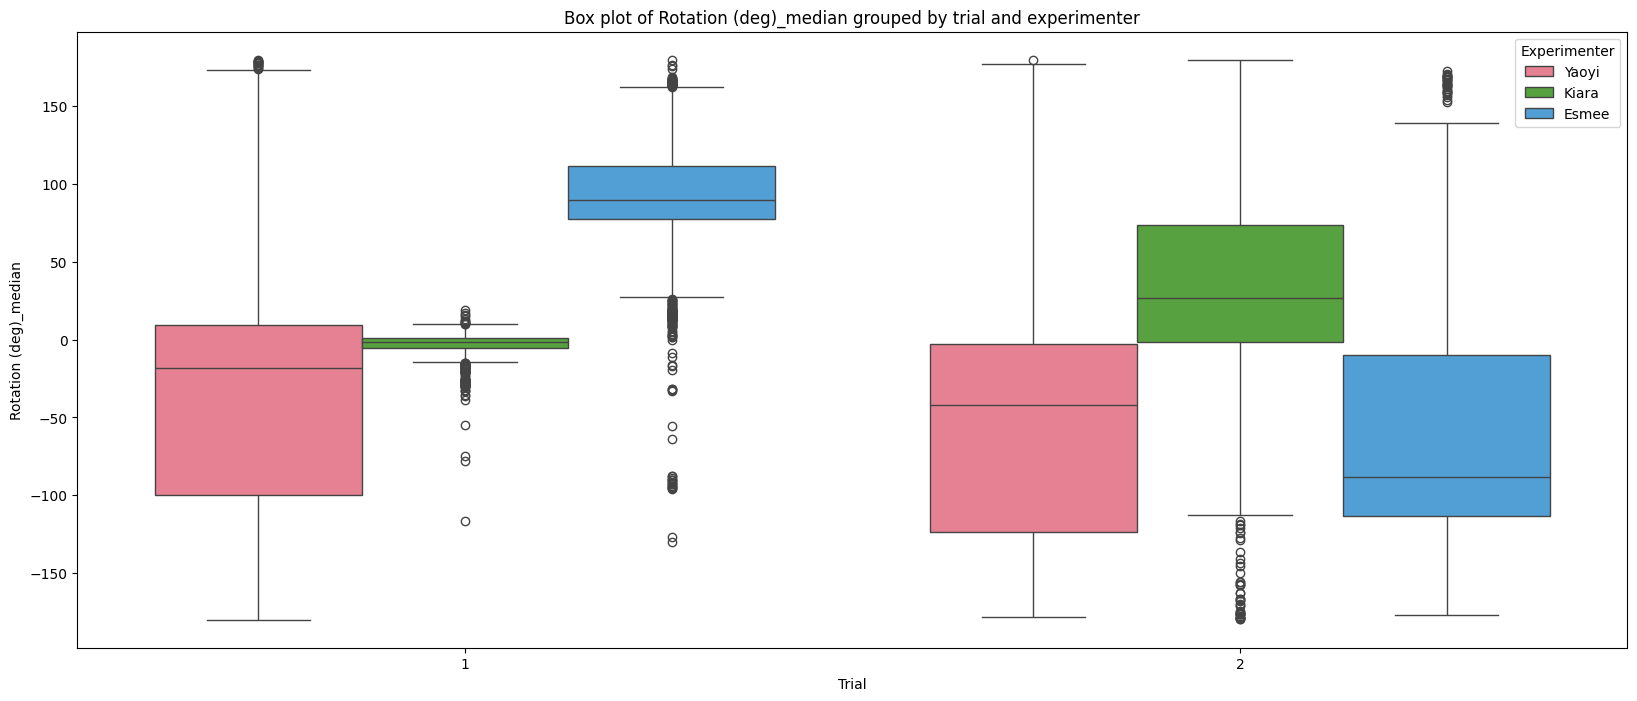

In [145]:
plot_boxplot(final_merged, 'Rotation (deg)_median')

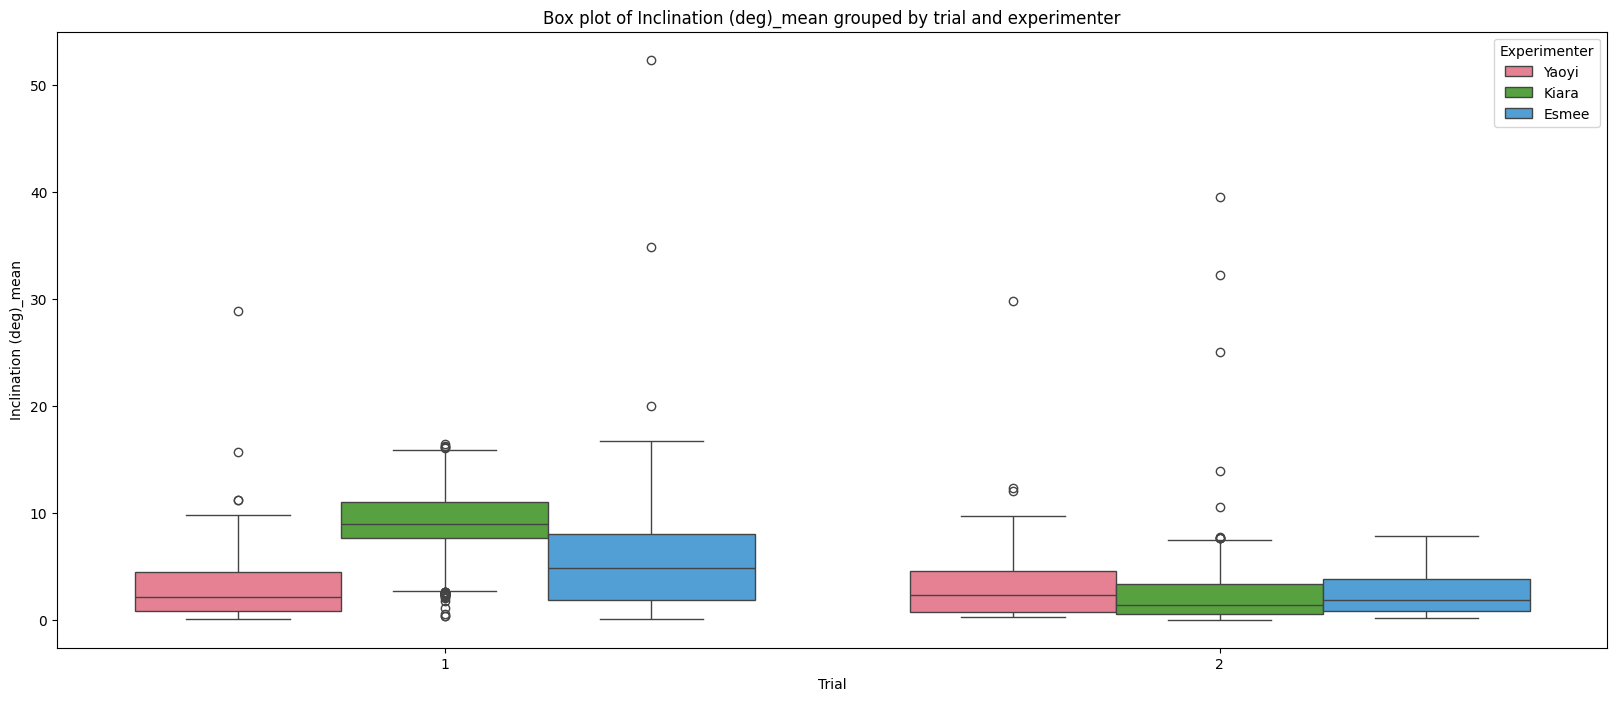

In [146]:
plot_boxplot(final_merged, 'Inclination (deg)_mean')

In [147]:
def plot_linechart(df, sensor_to_be_plotted):

    df = pd.DataFrame(df)

    plt.figure(figsize=(30, 6))
    sns.lineplot(data=df, x='timestamp', y=sensor_to_be_plotted, hue='experimenter', style='trial', markers=True)
    plt.title('Line chart of {} grouped by experimenter and trial'.format(sensor_to_be_plotted))
    plt.xlabel('Timestamp')
    plt.ylabel(sensor_to_be_plotted)
    plt.legend(title='Experimenter')
    plt.show()

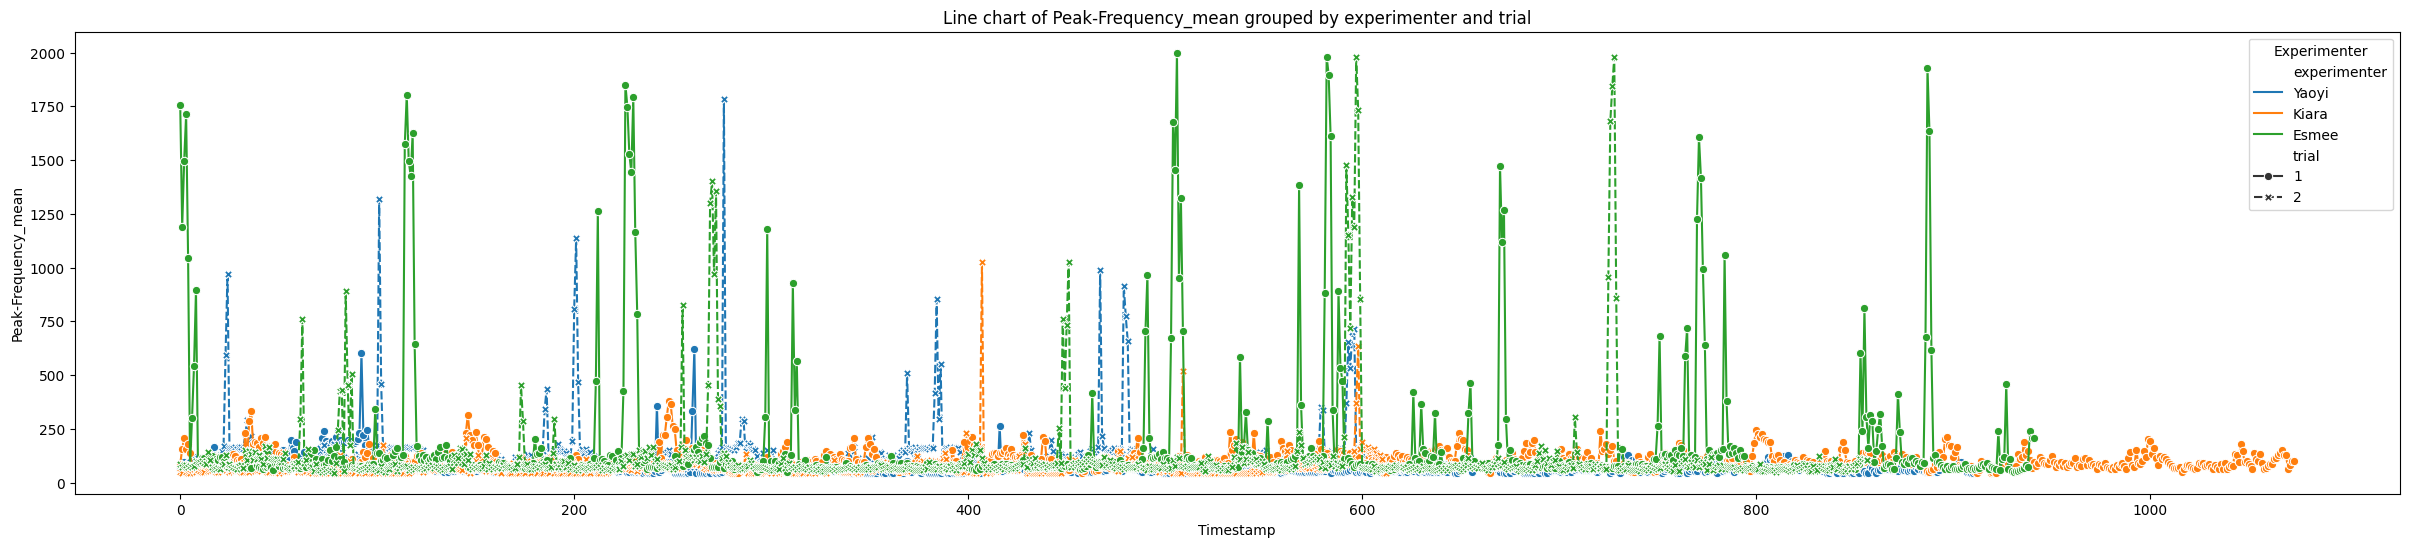

In [148]:
plot_linechart(final_merged, 'Peak-Frequency_mean')

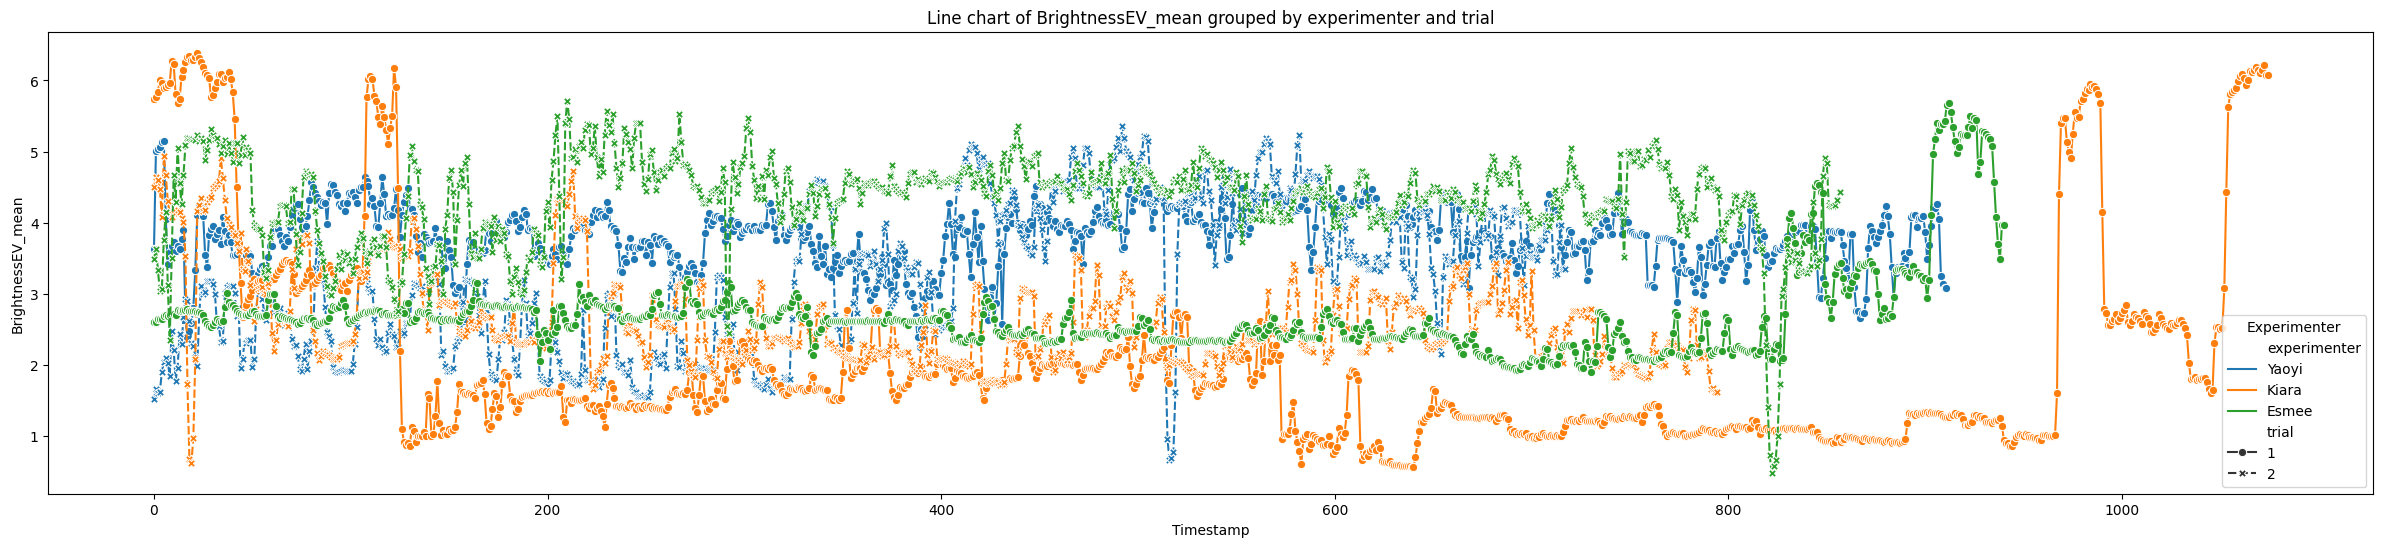

In [149]:
plot_linechart(final_merged, 'BrightnessEV_mean')

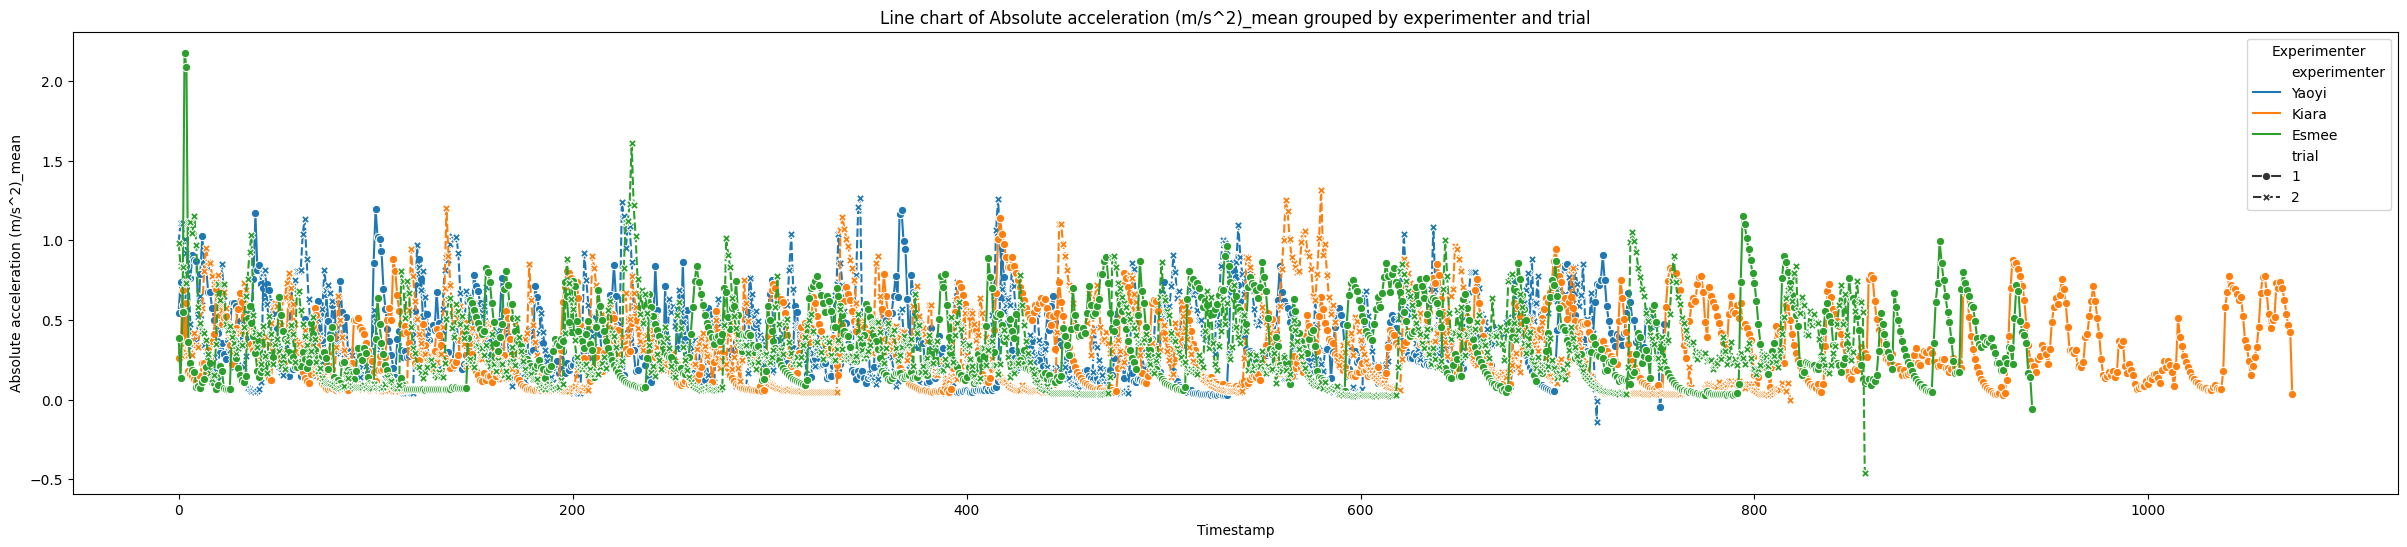

In [150]:
plot_linechart(final_merged, 'Absolute acceleration (m/s^2)_mean')

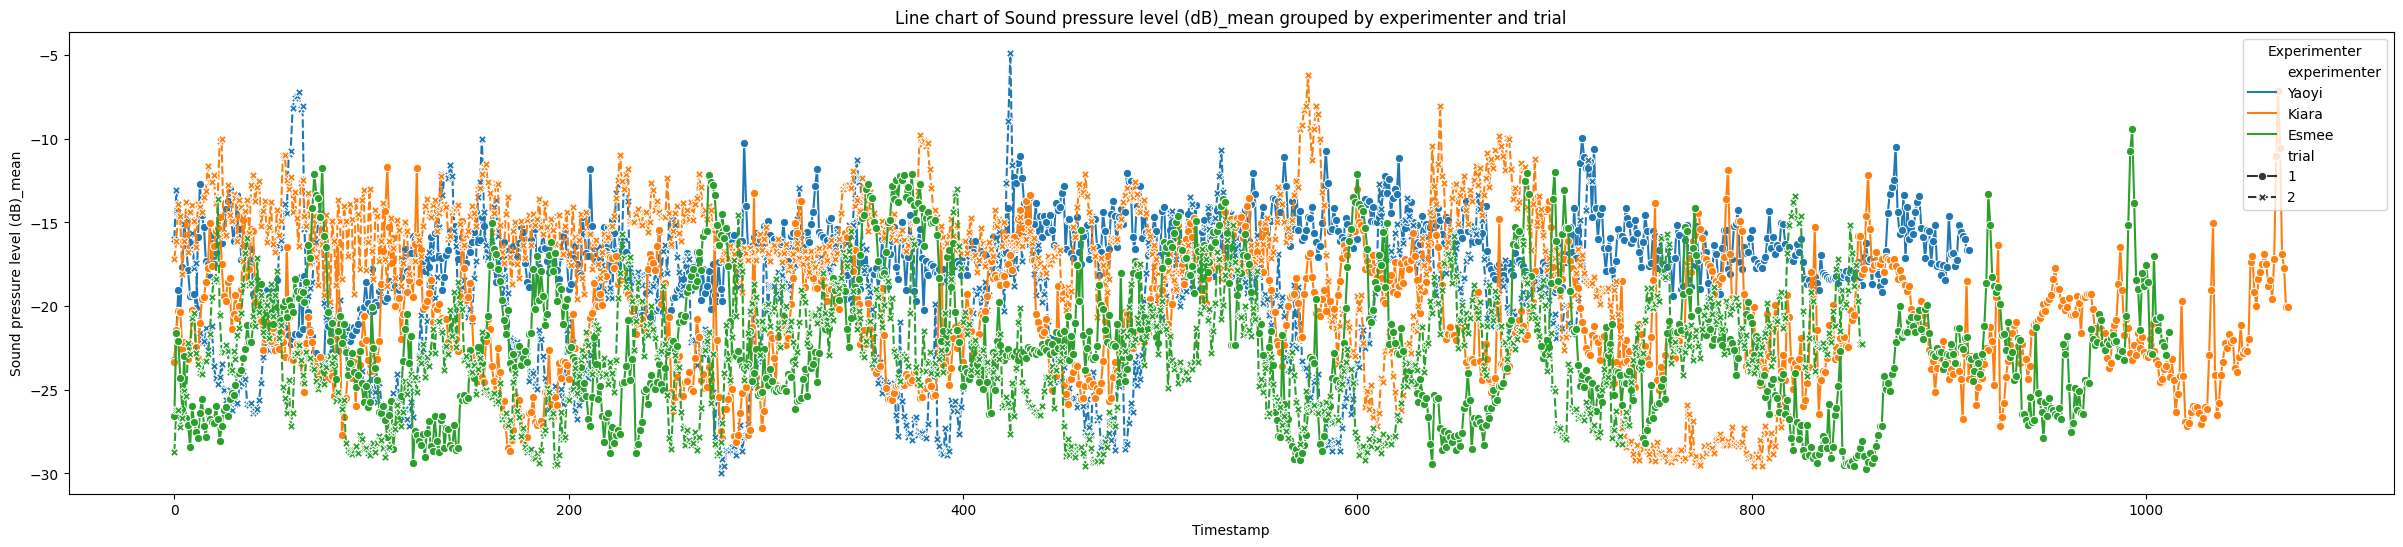

In [151]:
plot_linechart(final_merged, 'Sound pressure level (dB)_mean')

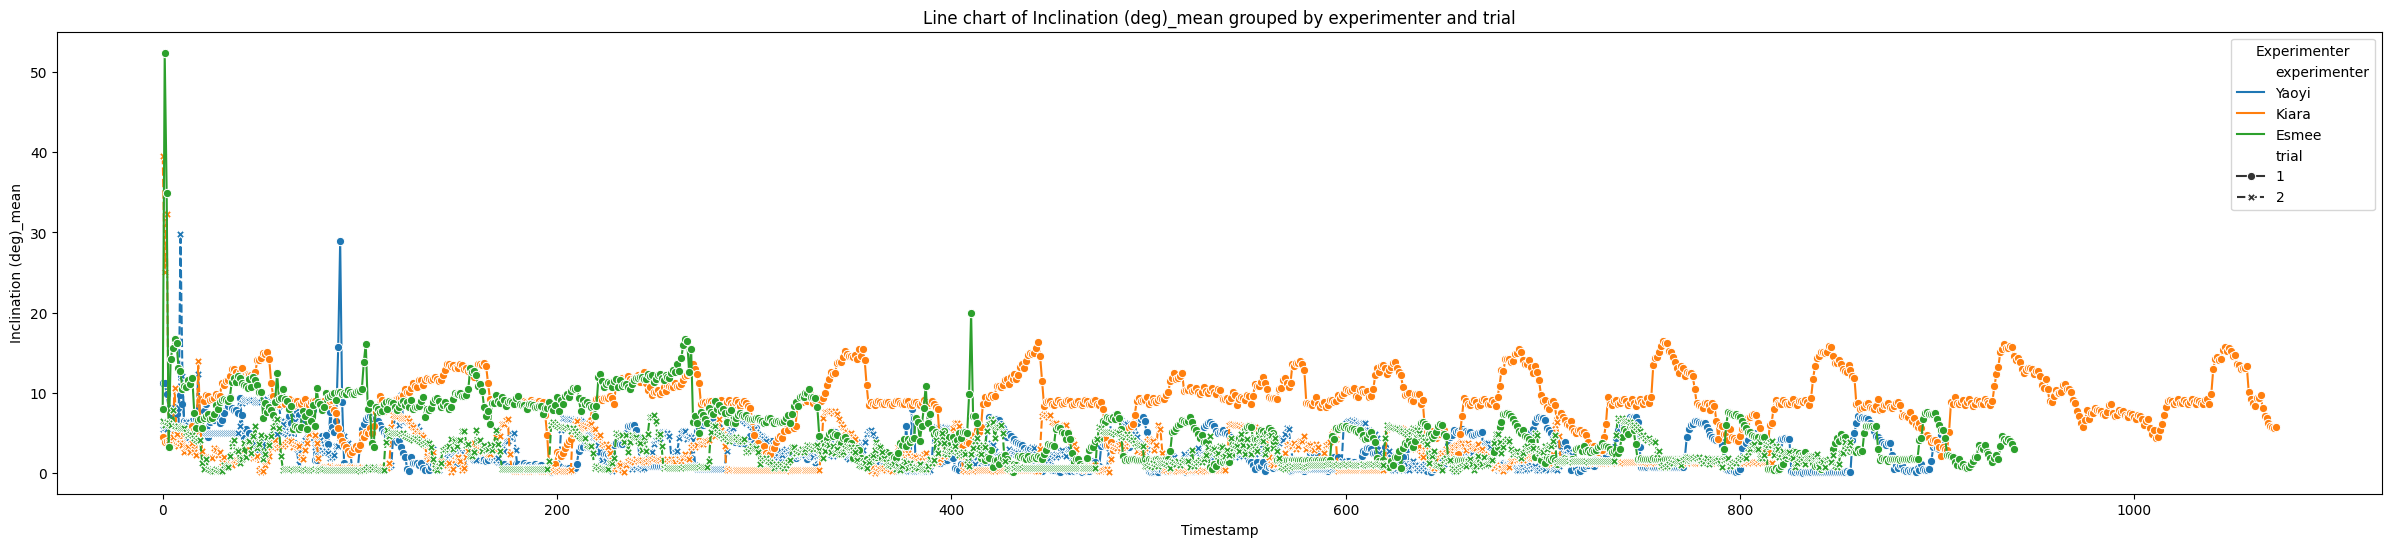

In [152]:
plot_linechart(final_merged, 'Inclination (deg)_mean')

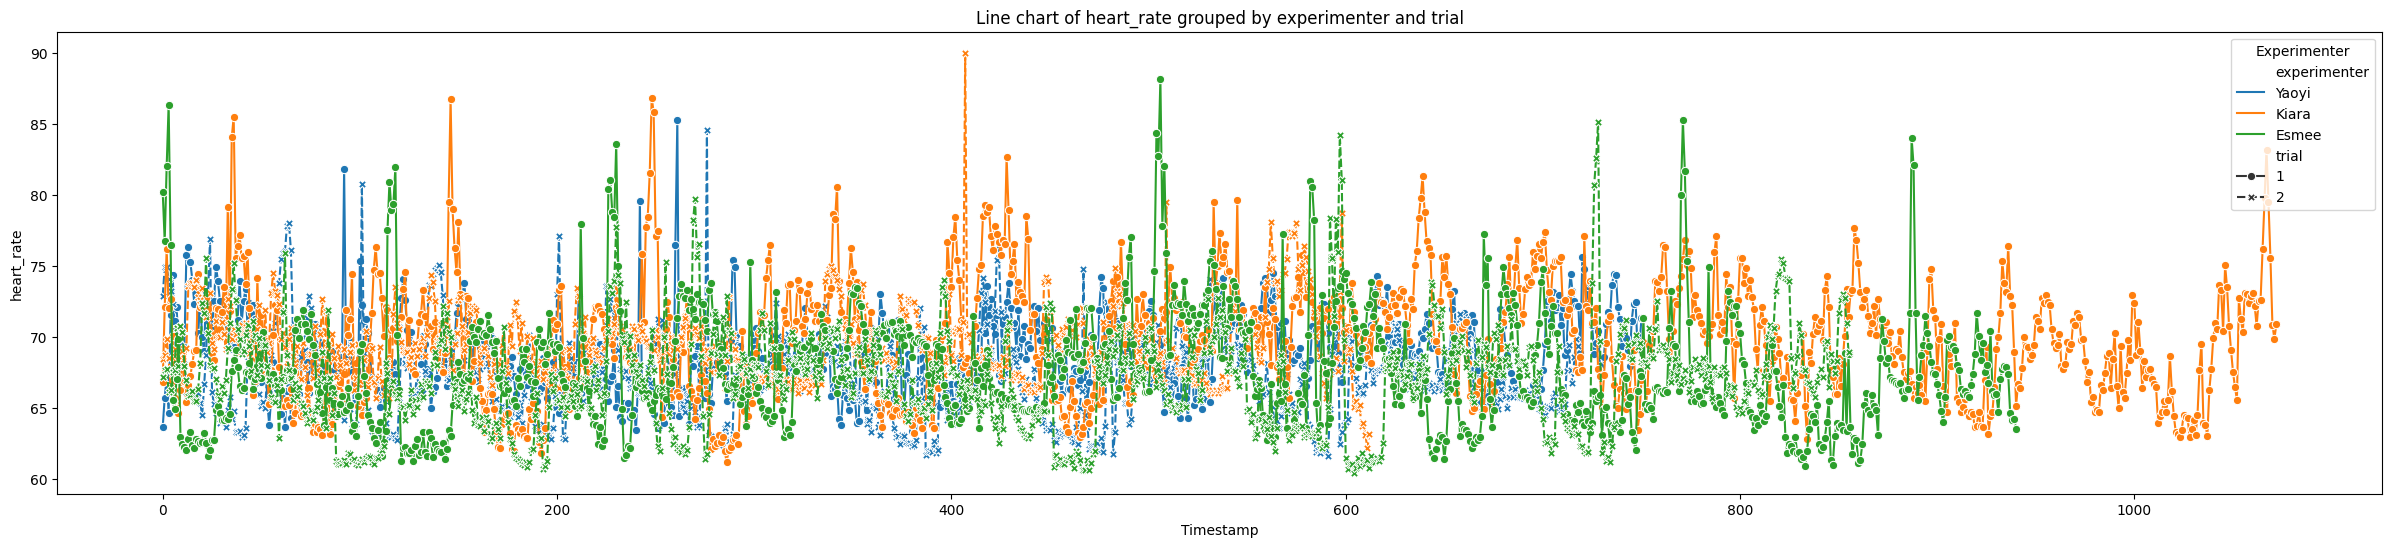

In [153]:
plot_linechart(final_merged, 'heart_rate')

In [154]:
def prepare_data(
    df: pd.DataFrame,
    data: Optional[Union[str, List[str], np.ndarray]] = None,
    ) -> np.ndarray:
    """
    This function prepares the data for plotting.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    column (str): The column name in the DataFrame.
    data (Union[str, List[str], np.ndarray], optional): The data to be plotted. If None,
    all data will be plotted.

    Returns:
    np.ndarray: An array containing the prepared data.
    """
    # If data is not specified, get all unique data
    if data is None:
        data = df.columns.tolist()
    # If data is a single string, make it a list
    elif isinstance(data, str):
        data = [data]

    # Convert data to a numpy array
    data = np.array(data)

    # Assert that data is a numpy array
    assert isinstance(data, np.ndarray), "data must be a numpy array"

    return data

In [155]:
def dot_plots(
    df: pd.DataFrame,
    ids: Optional[Union[str, List[str], np.ndarray]] = None,
    variables: Optional[Union[str, List[str], np.ndarray]] = None,
    mark_outliers: bool = False  # Added parameter for marking outliers
    ) -> None:
    """
    This function plots the change in value for each unique variable over time.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    ids (Union[str, List[str], np.ndarray], optional): The id(s) to be plotted. If None,
    all ids will be plotted.
    variables (Union[str, List[str], np.ndarray], optional): The variable(s) to be
    plotted. If None, all variables will be plotted.
    mark_outliers (bool, optional): Whether to mark outliers with red color.

    Returns:
    None
    """

    ids = prepare_data(df, ids)
    variables = prepare_data(df, variables)
    assert ids is not None
    assert variables is not None

    # Create a Pastel colormap
    pastel_colors = ['#FFCCCC', '#FFCC99', '#FFCC66', '#FFFF66', '#CCFFCC', '#CCFFFF', '#99CCFF',
                     '#9999FF', '#FF99CC', '#FF99FF', '#FFCCFF', '#FF9966', '#FFFF99', '#66FF99',
                     '#66FFFF', '#99CC99', '#99CCCC', '#669999', '#666699', '#6699CC', '#6699FF',
                     '#CCCC99', '#CC9999', '#CC99CC', '#CC99FF', '#CC6699', '#CCCC66']

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(len(variables), 1, figsize=(10, 5 * len(variables)))

    # If there's only one subplot, axs will not be a list. We need to make it a list.
    if len(variables) == 1:
        axs = [axs]

    # Plot the change in value for each unique variable over time
    for i, variable in enumerate(variables):
        df_variable = df[(df.columns[df.columns == variable]) & (df["experimenter"].isin(ids))]
        for idx, id in enumerate(df_variable["experimenter"].unique()):
            df_id = df_variable[df_variable["experimenter"] == id]
            df_id = df_id.sort_values(by='timestamp')  # Sort by time within each group of id and variable
            x = df_id["timestamp"]
            y = df_id[variable]
            for j in range(len(x)):
                if mark_outliers and df_id["outlier"].iloc[j] == 1:  # Check if mark_outliers is True and if the value is an outlier
                    axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color='red', markersize=3)  # Mark outliers with red color
                else:
                    axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color=pastel_colors[idx], markersize=3)
        axs[i].set_title(variable)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

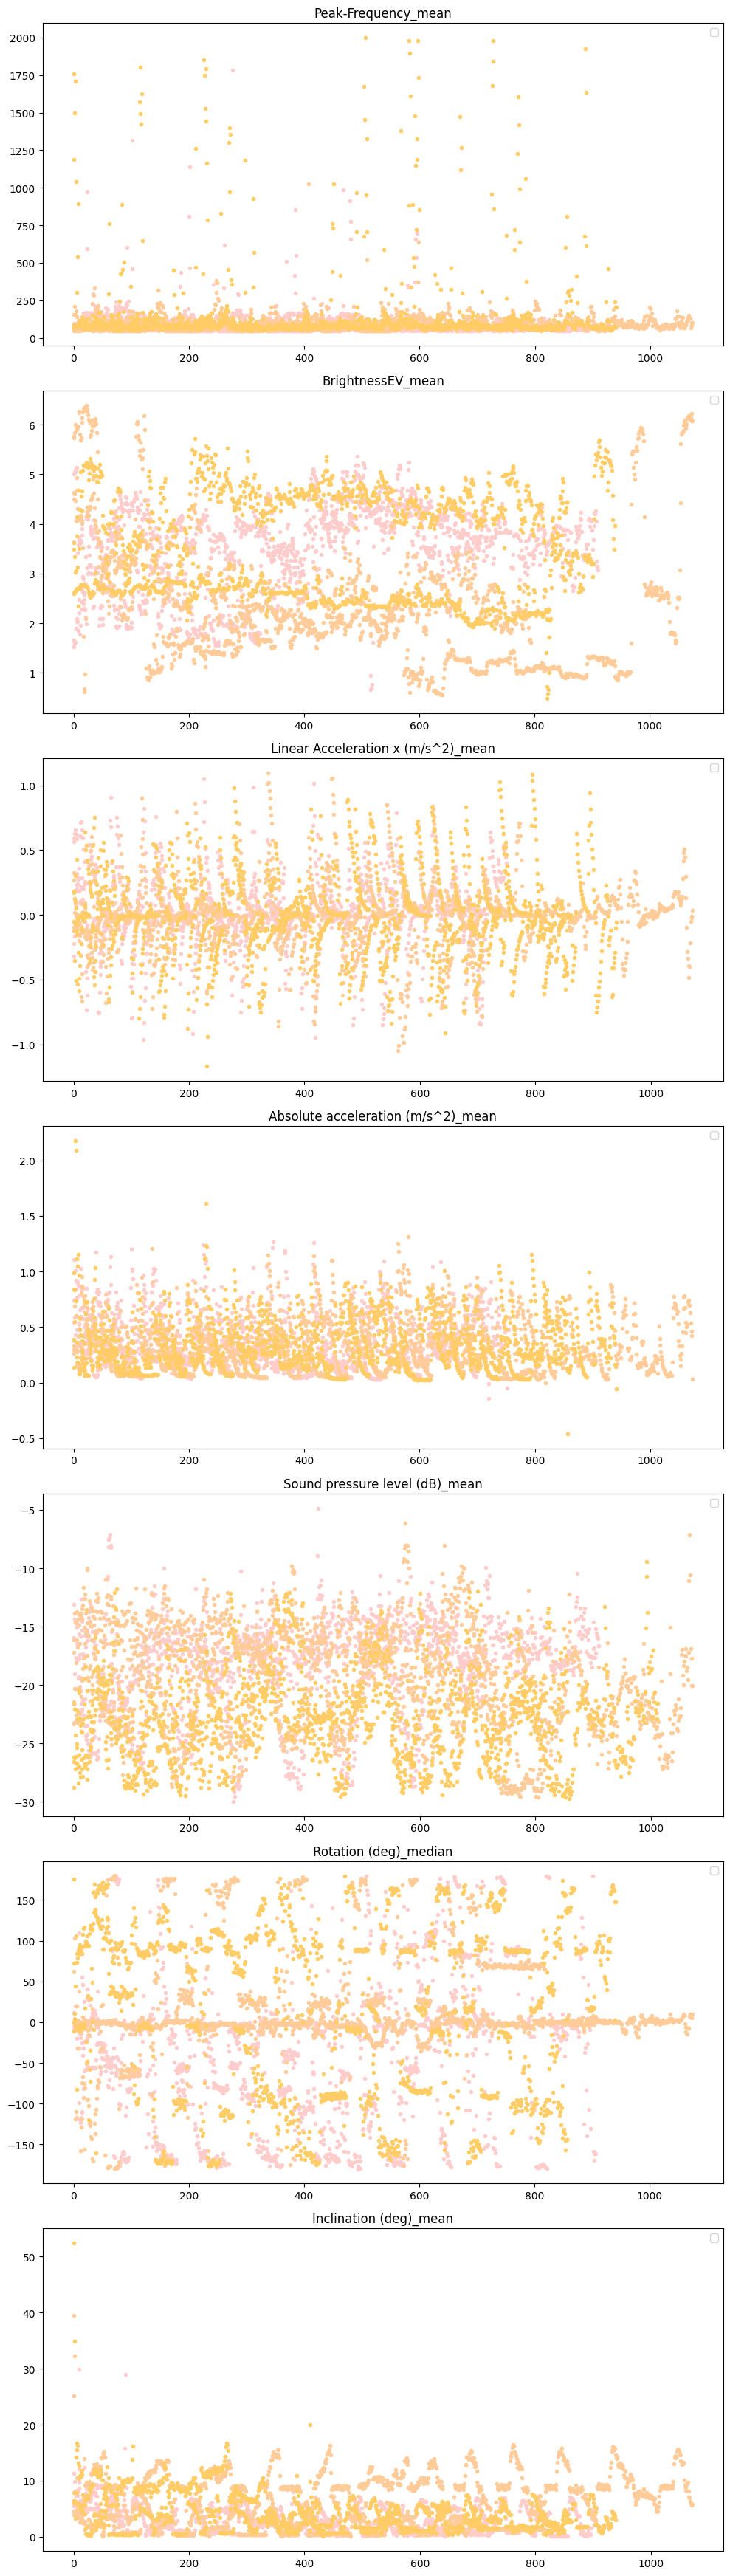

In [156]:
dot_plots(final_merged, ['Yaoyi', 'Esmee', 'Kiara'], ['Peak-Frequency_mean', 'BrightnessEV_mean', 'Linear Acceleration x (m/s^2)_mean', 'Absolute acceleration (m/s^2)_mean', 'Sound pressure level (dB)_mean', 'Rotation (deg)_median', 'Inclination (deg)_mean'])

# **Missing Value**

In [157]:
final_merged.isna().sum()

timestamp                                 1
BrightnessEV_max                        104
BrightnessEV_min                        104
BrightnessEV_median                     104
BrightnessEV_mean                       104
BrightnessEV_std                        106
trial                                     0
experimenter                              0
Peak-Frequency_max                      283
Peak-Frequency_min                      283
Peak-Frequency_median                   283
Peak-Frequency_mean                     283
Peak-Frequency_std                      285
Sound pressure level (dB)_max            10
Sound pressure level (dB)_min            10
Sound pressure level (dB)_median         10
Sound pressure level (dB)_mean           10
Sound pressure level (dB)_std            10
Linear Acceleration x (m/s^2)_max       246
Linear Acceleration x (m/s^2)_min       246
Linear Acceleration x (m/s^2)_median    246
Linear Acceleration x (m/s^2)_mean      246
Linear Acceleration x (m/s^2)_st

# *LOCF*

In [158]:
def interpolate_group(group):
    # group = group.set_index('timestamp')
    group = group.interpolate(method='linear', axis=0)
    group.reset_index(drop=True, inplace=True)
    return group

In [159]:
df_locf = final_merged.copy(deep=True)
groups = df_locf.groupby("experimenter")
df_locf = groups.apply(interpolate_group)
df_locf.reset_index(drop=True, inplace=True)

# *Median*

In [160]:
def fill_missing_values_with_median(df, columns_to_fill):
    # Preserve the original index
    original_index = df.index
    
    # Ensure that 'timestamp' is sorted within each group for correct calculation of nearest timestamps
    df = df.sort_values(by=['experimenter', 'trial', 'timestamp'])
    
    # Function to fill missing values within each group
    def fill_group(group):
        timestamps = group['timestamp'].to_numpy()
        n = len(timestamps)
        
        for column in columns_to_fill:
            values = group[column].to_numpy()
            
            for i in range(n):
                if pd.isna(values[i]):
                    # Find the nearest three timestamps
                    left, right = i - 5, i + 5
                    nearest_values = []
                    
                    # Collect nearest left values
                    while left >= 0 and len(nearest_values) < 3:
                        if not pd.isna(values[left]):
                            nearest_values.append(values[left])
                        left -= 1
                    
                    # Collect nearest right values
                    while right < n and len(nearest_values) < 3:
                        if not pd.isna(values[right]):
                            nearest_values.append(values[right])
                        right += 1
                    
                    # Compute the median of the nearest three values
                    if len(nearest_values) > 0:
                        median_value = np.median(nearest_values)
                        values[i] = median_value
            
            group[column] = values
        
        return group
    
    # Apply the function to each group
    df = df.groupby(['experimenter', 'trial'], group_keys=False).apply(fill_group)
    
    # Restore the original index
    df = df.set_index(original_index)
    return df

In [161]:
columns_to_be_interpolated = list(final_merged.columns)
unaffected_columns = ['timestamp', 'trial', 'experimenter']
for i in unaffected_columns:
    columns_to_be_interpolated.remove(i)

In [162]:
df_median = final_merged.copy(deep=True)
df_median = fill_missing_values_with_median(df_median, columns_to_be_interpolated)
df_median
# df = df_median

timestamp  BrightnessEV_max  BrightnessEV_min  BrightnessEV_median  \
0       0.000000          2.614682          2.590836             2.598828   
1       1.000000          2.630364          2.566588             2.614682   
2       2.000000          2.661225          2.622545             2.638141   
3       3.000000          2.653571          2.638141             2.653571   
4       4.000000          2.668838          2.638141             2.645877   
...          ...               ...               ...                  ...   
5399  718.000000          3.316994          3.233336             3.263955   
5400  719.000000          3.316994          3.233336             3.263955   
5401  720.000000          4.072522          3.330477             3.762476   
5402  720.085676          4.072522          3.346145             3.762476   
5403         NaN          3.364396          3.346145             3.353096   

      BrightnessEV_mean  BrightnessEV_std trial experimenter  \
0              2.600805          0.006804     1        Esmee   
1              2.606115          0.020364     1        Esmee   
2              2.642755          0.010039     1        Esmee   
3              2.647918          0.006817     1        Esmee   
4              2.649440          0.009991     1        Esmee   
...                 ...               ...   ...          ...   
5399           3.272730          0.027808     2        Yaoyi   
5400           3.272730          0.027808     2        Yaoyi   
5401           3.730140          0.230926     2        Yaoyi   
5402           3.730140          0.230926     2        Yaoyi   
5403           3.353767          0.007031     2        Yaoyi   

      Peak-Frequency_max  Peak-Frequency_min  ...  Inclination (deg)_min  \
0              1757.8125           1757.8125  ...               7.939696   
1              2203.1250             46.8750  ...              48.666906   
2              2203.1250             46.8750  ...              22.788425   
3              2203.1250             70.3125  ...               1.777635   
4              2203.1250             46.8750  ...               5.400174   
...                  ...                 ...  ...                    ...   
5399             93.7500             46.8750  ...               2.326561   
5400             70.3125             23.4375  ...               2.326561   
5401             70.3125             46.8750  ...               2.247643   
5402             70.3125             46.8750  ...               2.247643   
5403            140.6250             46.8750  ...               2.261942   

      Inclination (deg)_median  Inclination (deg)_mean  Inclination (deg)_std  \
0                     7.939696                7.939696               2.497690   
1                    52.390605               52.390605               5.266105   
2                    34.900274               34.900274              17.128741   
3                     3.256084                3.256084               2.090842   
4                    14.200188               14.200188              12.445098   
...                        ...                     ...                    ...   
5399                  2.393080                2.393080               0.307798   
5400                  2.393080                2.393080               0.307798   
5401                  2.291738                2.291738               0.273859   
5402                  2.291738                2.291738               0.144099   
5403                  2.331203                2.331203               0.144099   

      Rotation (deg)_max  Rotation (deg)_min  Rotation (deg)_median  \
0             175.802332          175.802332             175.802332   
1              73.339843           72.144628              72.742236   
2              85.402887          -63.487116              10.957885   
3              74.525987           15.118749              44.822368   
4             114.958296           97.226833             106.092565   
.

In [163]:
df_median = df_median.dropna()

In [164]:
# def assign_stress_level(df):
#     # Function to assign stress level based on quantiles
#     def calculate_stress_level(group):
#         Q25, Q50, Q75 = group['heart_rate'].quantile([0.25, 0.55, 0.85])
#         bins = [-float('inf'), Q25, Q50, Q75, float('inf')]
#         labels = [0, 1, 2, 3]
#         group['stress_level'] = pd.cut(group['heart_rate'], bins=bins, labels=labels, right=False).astype(int)
#         return group

#     # Group by 'trial' and 'experimenter' and apply the function without losing the original index
#     df = df.groupby(['trial', 'experimenter'], group_keys=False).apply(calculate_stress_level)
#     return df

In [165]:
# df_median = assign_stress_level(df_median)

In [166]:
# plt.figure(figsize=(10, 6))
# sns.countplot(x='stress_level', data=df_median, palette='viridis')
# plt.title('Distribution of Stress Levels')
# plt.xlabel('Stress Level')
# plt.ylabel('Count')
# plt.show()

# **Outlier**

### Kalman

In [167]:
df_kalman = df_median.copy(deep=True)
outlier = KalmanFilters()
for i in columns_to_be_interpolated:
    df_kalman = outlier.apply_kalman_filter(df_kalman, i)

In [168]:
def replace_columns_with_kalman(df):
    
    columns_to_drop = []
    kalman_columns = []

    for col in df.columns:
        if col.endswith(('_max', '_min', '_median', '_std', '_mean')):
            columns_to_drop.append(col)
            kalman_col = col + '_kalman'
            if kalman_col in df.columns:
                kalman_columns.append(kalman_col)
            else:
                raise ValueError(f"Kalman column {kalman_col} does not exist for {col}")

    # Drop the original columns
    df = df.drop(columns=columns_to_drop)
    
    # Rename the _kalman columns to the original column names
    kalman_columns_rename = {kalman: kalman.replace('_kalman', '') for kalman in kalman_columns}
    df = df.rename(columns=kalman_columns_rename)

    return df

In [169]:
df = replace_columns_with_kalman(df_kalman)
df['heart_rate'] = df['heart_rate_kalman']
df.drop(columns=['heart_rate_kalman'], inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

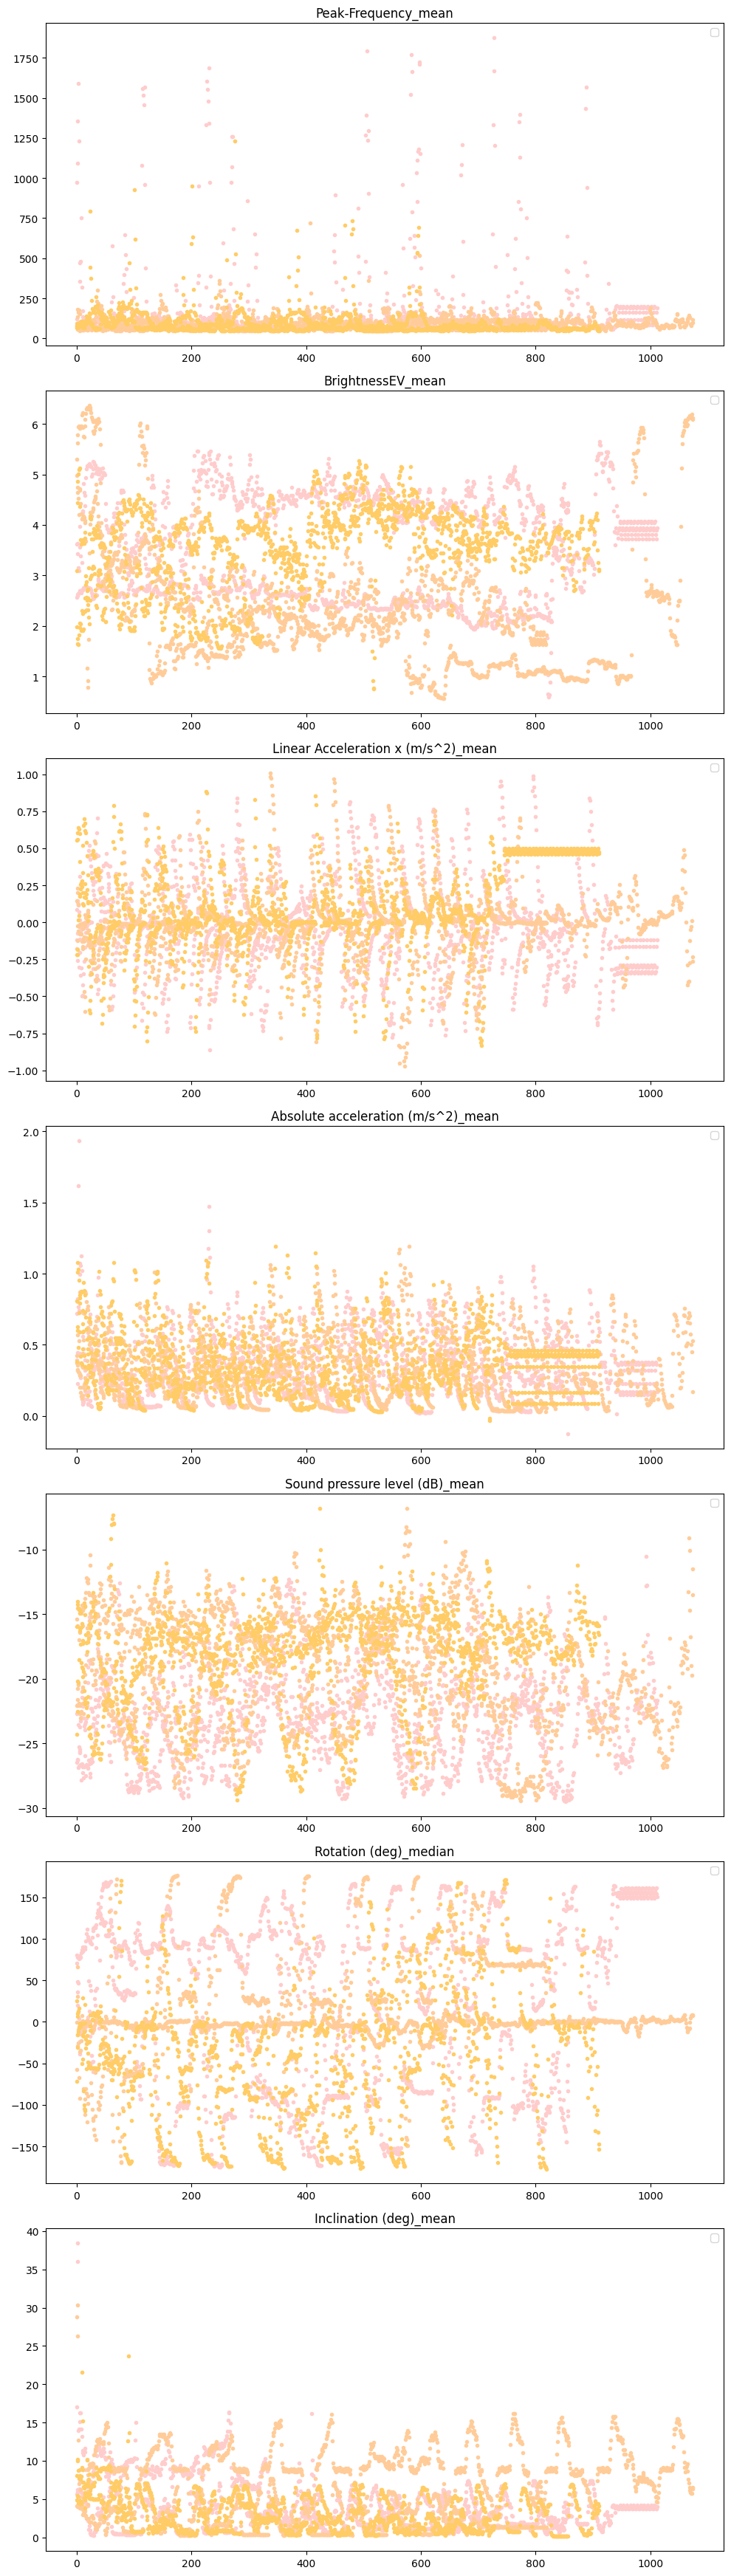

In [170]:
dot_plots(df, ['Yaoyi', 'Esmee', 'Kiara'], ['Peak-Frequency_mean', 'BrightnessEV_mean', 'Linear Acceleration x (m/s^2)_mean', 'Absolute acceleration (m/s^2)_mean', 'Sound pressure level (dB)_mean', 'Rotation (deg)_median', 'Inclination (deg)_mean'])

### Distance Based

In [171]:
# df_distance_based = df_median.copy(deep=True)
# outlier2 = DistanceBasedOutlierDetection()
# outlier2.local_outlier_factor(df_distance_based, columns_to_be_interpolated, 'euclidean', 5)

### Distribution Based:

In [172]:
# class DistributionBasedOutlierDetection:

#     # Finds outliers in the specified column of datatable and adds a binary column with
#     # the same name extended with '_outlier' that expresses the result per data point.
#     def chauvenet(self, data_table, col, C):
#         # Taken partly from: https://www.astro.rug.nl/software/kapteyn/

#         # Computer the mean and standard deviation.
#         mean = data_table[col].mean()
#         std = data_table[col].std()
#         N = len(data_table.index)
#         criterion = 1.0/(C*N)

#         # Consider the deviation for the data points.
#         deviation = abs(data_table[col] - mean)/std

#         # Express the upper and lower bounds.
#         low = -deviation/math.sqrt(C)
#         high = deviation/math.sqrt(C)
#         prob = []
#         mask = []

#         # Pass all rows in the dataset.
#         for i in range(0, len(data_table.index)):
#             # Determine the probability of observing the point
#             prob.append(
#                 1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i])))
#             # And mark as an outlier when the probability is below our criterion.
#             mask.append(prob[i] < criterion)
#         data_table[col + '_outlier'] = mask
#         return data_table

#     # Fits a mixture model towards the data expressed in col and adds a column with the probability
#     # of observing the value given the mixture model.
#     def mixture_model(self, data_table, col):
#         print('Applying mixture models')
        
#         # Fit a mixture model to our data.
#         data = data_table[data_table[col].notnull()][col]
#         g = GaussianMixture(n_components=3, max_iter=100, n_init=1)
#         reshaped_data = np.array(data.values.reshape(-1, 1))
#         g.fit(reshaped_data)
    
#         # Predict the log probabilities
#         log_probs = g.score_samples(reshaped_data)
        
#         # Convert log probabilities to probabilities
#         probs = np.exp(log_probs)
    
#         # Create the data frame with probabilities
#         data_probs = pd.DataFrame(probs, index=data.index, columns=[col+'_mixture'])
    
#         # Concatenate the probabilities with the original data table
#         data_table = pd.concat([data_table, data_probs], axis=1)
        
#         # Define a threshold for outliers
#         threshold = np.percentile(probs, 5)
        
#         # Create a column to mark outliers with True or False
#         data_table[col + '_outlier'] = data_table[col + '_mixture'] < threshold
    
#         return data_table

In [173]:
# outlier = DistributionBasedOutlierDetection()
# df_with_outlier = outlier.mixture_model(final_merged, 'Peak-Frequency_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'BrightnessEV_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Linear Acceleration x (m/s^2)_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Absolute acceleration (m/s^2)_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Sound pressure level (dB)_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Inclination (deg)_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Rotation (deg)_median')

In [174]:
# df_with_outlier

In [175]:
# from matplotlib.lines import Line2D

# def dot_plots_legend(
#     df: pd.DataFrame,
#     ids: Optional[Union[str, List[str], np.ndarray]] = None,
#     variables: Optional[Union[str, List[str], np.ndarray]] = None,
#     mark_outliers: bool = False  # Added parameter for marking outliers
#     ) -> None:
#     """
#     This function plots the change in value for each unique variable over time.

#     Parameters:
#     df (pandas.DataFrame): The DataFrame containing the data.
#     ids (Union[str, List[str], np.ndarray], optional): The id(s) to be plotted. If None,
#     all ids will be plotted.
#     variables (Union[str, List[str], np.ndarray], optional): The variable(s) to be
#     plotted. If None, all variables will be plotted.
#     mark_outliers (bool, optional): Whether to mark outliers with red color.

#     Returns:
#     None
#     """

#     ids = prepare_data(df, ids)
#     variables = prepare_data(df, variables)
#     assert ids is not None
#     assert variables is not None

#     # Create a Pastel colormap
#     pastel_colors = ['#FFCCCC', '#FFCC99', '#FFCC66', '#FFFF66', '#CCFFCC', '#CCFFFF', '#99CCFF',
#                      '#9999FF', '#FF99CC', '#FF99FF', '#FFCCFF', '#FF9966', '#FFFF99', '#66FF99',
#                      '#66FFFF', '#99CC99', '#99CCCC', '#669999', '#666699', '#6699CC', '#6699FF',
#                      '#CCCC99', '#CC9999', '#CC99CC', '#CC99FF', '#CC6699', '#CCCC66']

#     # Create a figure and a set of subplots
#     fig, axs = plt.subplots(len(variables), 1, figsize=(10, 5 * len(variables)))

#     # If there's only one subplot, axs will not be a list. We need to make it a list.
#     if len(variables) == 1:
#         axs = [axs]

#     # Plot the change in value for each unique variable over time
#     for i, variable in enumerate(variables):
#         df_variable = df[(df.columns[df.columns == variable]) & (df["experimenter"].isin(ids))]
#         for idx, id in enumerate(df_variable["experimenter"].unique()):
#             df_id = df_variable[df_variable["experimenter"] == id]
#             df_id = df_id.sort_values(by='timestamp')  # Sort by time within each group of id and variable
#             x = df_id["timestamp"]
#             y = df_id[variable]
#             for j in range(len(x)):
#                 if mark_outliers:
#                     # Determine the outlier column name based on the variable
#                     outlier_column = f"{variable}_outlier"
#                     # Check if the value is an outlier in the respective column
#                     if df_id[outlier_column].iloc[j] == 1:
#                         axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color='red', markersize=3)  # Mark outliers with red color
#                     else:
#                         axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color=pastel_colors[idx], markersize=3)
#                 else:
#                     axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color=pastel_colors[idx], markersize=3)
#         axs[i].set_title(variable)

#         if mark_outliers:
#             legend_elements = [Line2D([0], [0], marker='o', color='red', label='Outliers', markersize=5, linestyle='')]
#             axs[i].legend(handles=legend_elements, scatterpoints=1)

#     plt.tight_layout()
#     plt.show()

In [176]:
# dot_plots_legend(df_with_outlier, ['Yaoyi', 'Esmee', 'Kiara'], ['Peak-Frequency_mean', 'BrightnessEV_mean', 'Linear Acceleration x (m/s^2)_mean', 'Absolute acceleration (m/s^2)_mean', 'Sound pressure level (dB)_mean', 'Rotation (deg)_median', 'Inclination (deg)_mean'], mark_outliers=True)

In [177]:
# print(f"{len(df_with_outlier[df_with_outlier['Peak-Frequency_mean_outlier'] == 1])} Peak-Frequency_mean outliers were found")

In [178]:
# def replace_outliers_neighborhood_avg(data_frame, attributes_column='Peak-Frequency_mean', outlier_column_name='Peak-Frequency_mean_outlier'):
#     modified_data = data_frame.copy()
    
#     outlier_indices = modified_data.index[modified_data[outlier_column_name] == True].tolist()
    
#     for outlier_index in outlier_indices:
#         outlier_trial = modified_data.at[outlier_index, 'trial']
#         outlier_experimenter = modified_data.at[outlier_index, 'experimenter']
        
#         same_trial_experimenter_data = modified_data[
#             (modified_data['trial'] == outlier_trial) &
#             (modified_data['experimenter'] == outlier_experimenter)
#         ]
        
#         distances = cdist(
#             same_trial_experimenter_data[[attributes_column]],
#             same_trial_experimenter_data[[attributes_column]],
#             metric='euclidean'
#         )

#         neighborhood_threshold = 5 * np.std(same_trial_experimenter_data[attributes_column])
#         neighborhood_indices = np.where(distances <= neighborhood_threshold)[0]
#         neighborhood_mean = np.mean(same_trial_experimenter_data.iloc[neighborhood_indices][attributes_column])
        
#         # Change the attributes_column based on the outlier_column
#         modified_data.at[outlier_index, attributes_column] = neighborhood_mean
        
#         # Update the outlier column to indicate the outlier has been replaced
#         modified_data.at[outlier_index, outlier_column_name] = False
    
#     return modified_data


In [179]:
# df = replace_outliers_neighborhood_avg(df_with_outlier)

In [180]:
# df

# **Noise**

## Low Pass Filter

In [181]:
columns_to_be_interpolated.remove('heart_rate')
lpf = LowPassFilter()
for i in columns_to_be_interpolated:
    df = lpf.low_pass_filter(df, i, 0.01, 0.003)

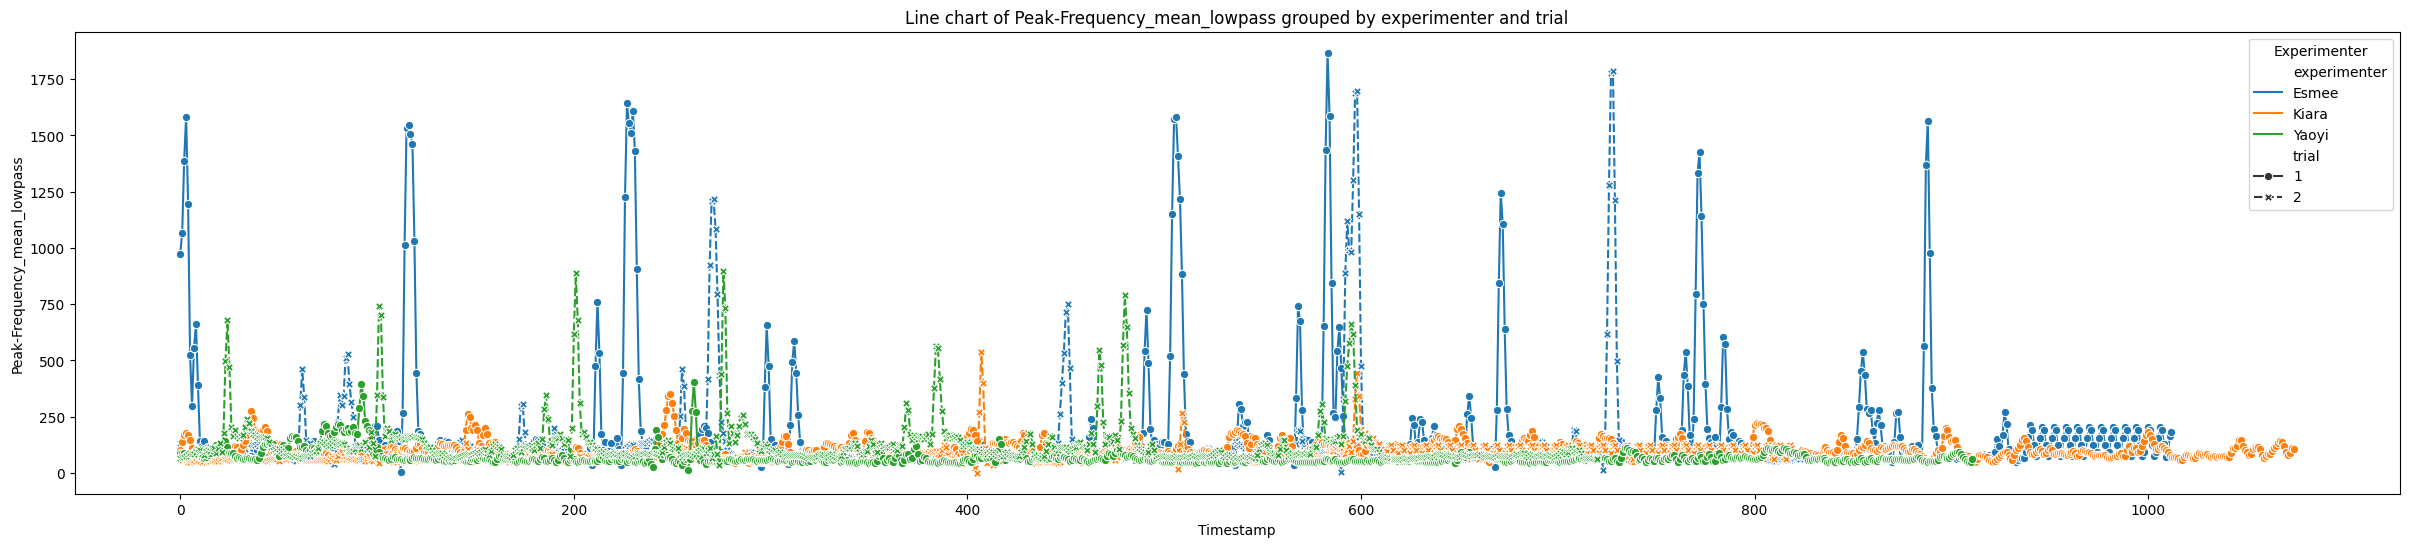

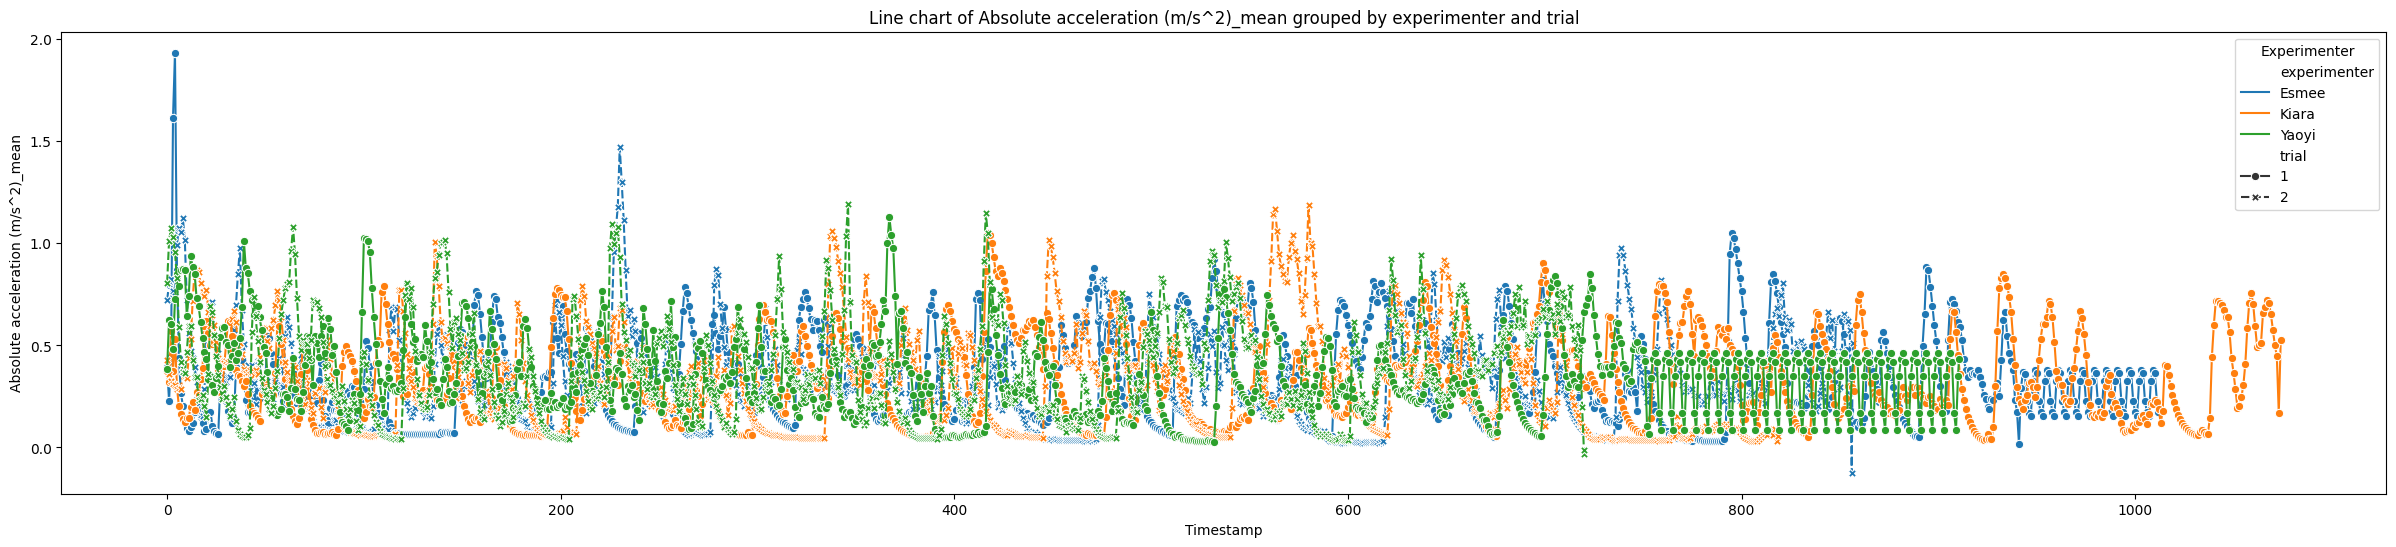

In [182]:
plot_linechart(df, 'Peak-Frequency_mean_lowpass')
plot_linechart(df, 'Absolute acceleration (m/s^2)_mean')

# **Add non-sensor attributes**

In [183]:
def update_seated(df, trial_value, experimenter_value, seated_value):

    if 'seated' not in df.columns:
        df['seated'] = 0

    condition = (df['trial'] == trial_value) & (df['experimenter'] == experimenter_value)
    df.loc[condition, 'seated'] = seated_value

    return df

In [184]:
df = update_seated(df, '1', 'Yaoyi', 0)
df = update_seated(df, '2', 'Yaoyi', 0)
df = update_seated(df, '1', 'Esmee', 1)
df = update_seated(df, '2', 'Esmee', 1)
df = update_seated(df, '1', 'Kiara', 1)
df = update_seated(df, '2', 'Kiara', 1)

In [185]:
df

timestamp trial experimenter  heart_rate  BrightnessEV_max  \
0       0.000000     1        Esmee   68.465820          2.580802   
1       1.000000     1        Esmee   73.454403          2.613668   
2       2.000000     1        Esmee   79.201486          2.646811   
3       3.000000     1        Esmee   84.039299          2.651543   
4       4.000000     1        Esmee   78.924446          2.663654   
...          ...   ...          ...         ...               ...   
5398  717.000000     2        Yaoyi   69.318192          3.432027   
5399  718.000000     2        Yaoyi   69.381193          3.351470   
5400  719.000000     2        Yaoyi   68.225364          3.327327   
5401  720.000000     2        Yaoyi   67.852647          3.849183   
5402  720.085676     2        Yaoyi   67.732458          4.005586   

      BrightnessEV_min  BrightnessEV_median  BrightnessEV_mean  \
0             2.550306             2.564398           2.566170   
1             2.561081             2.597678           2.592795   
2             2.603863             2.625846           2.627746   
3             2.627830             2.645233           2.641917   
4             2.635043             2.645684           2.647205   
...                ...                  ...                ...   
5398          3.351755             3.405640           3.398426   
5399          3.268920             3.306520           3.310085   
5400          3.244029             3.276742           3.283831   
5401          3.304500             3.616551           3.597505   
5402          3.333631             3.718637           3.690724   

      BrightnessEV_std  Peak-Frequency_max  ...  \
0             0.008711         1185.020793  ...   
1             0.016046         1495.038130  ...   
2             0.012084         1796.720995  ...   
3             0.008591         1985.082070  ...   
4             0.009520         2088.444051  ...   
...                ...                 ...  ...   
5398          0.031563          134.575404  ...   
5399          0.029071          115.059191  ...   
5400          0.028233           93.668442  ...   
5401          0.162725           82.503346  ...   
5402          0.207978           76.675623  ...   

      Inclination (deg)_min_lowpass  Inclination (deg)_median_lowpass  \
0                         15.557830                         17.001158   
1                         34.285005                         39.049920   
2                         27.819332                         34.270456   
3                         10.578147                         16.877999   
4                          6.120203                         11.520713   
...                             ...                               ...   
5398                       2.335391                          2.388500   
5399                       2.328028                          2.389488   
5400                       2.306713                          2.366480   
5401                       2.291950                          2.345071   
5402                       2.255527                          2.301311   

      Inclination (deg)_mean_lowpass  Inclination (deg)_std_lowpass  \
0                          17.034570                       4.185225   
1                          38.892197                       6.499583   
2                          34.208973                       8.376593   
3                          16.976148                       8.853697   
4                          11.591772                       7.952918   
...                              ...                            ...   
5398                        2.388012                       0.164459   
5399                        2.389313                       0.226930   
5400                        2.366582                       0.279826   
5401                        2.345230                       0.272760   
5402                        2.301557                       0.203359   

      Rotation (deg)_max_lowpass  Rotation

In [186]:
df.columns

Index(['timestamp', 'trial', 'experimenter', 'heart_rate', 'BrightnessEV_max',
       'BrightnessEV_min', 'BrightnessEV_median', 'BrightnessEV_mean',
       'BrightnessEV_std', 'Peak-Frequency_max', 'Peak-Frequency_min',
       'Peak-Frequency_median', 'Peak-Frequency_mean', 'Peak-Frequency_std',
       'Sound pressure level (dB)_max', 'Sound pressure level (dB)_min',
       'Sound pressure level (dB)_median', 'Sound pressure level (dB)_mean',
       'Sound pressure level (dB)_std', 'Linear Acceleration x (m/s^2)_max',
       'Linear Acceleration x (m/s^2)_min',
       'Linear Acceleration x (m/s^2)_median',
       'Linear Acceleration x (m/s^2)_mean',
       'Linear Acceleration x (m/s^2)_std',
       'Linear Acceleration y (m/s^2)_max',
       'Linear Acceleration y (m/s^2)_min',
       'Linear Acceleration y (m/s^2)_median',
       'Linear Acceleration y (m/s^2)_mean',
       'Linear Acceleration y (m/s^2)_std',
       'Linear Acceleration z (m/s^2)_max',
       'Linear Acceleration

In [187]:
lowpass_columns = [i + "_lowpass" for i in columns_to_be_interpolated]
lowpass_columns

['BrightnessEV_max_lowpass',
 'BrightnessEV_min_lowpass',
 'BrightnessEV_median_lowpass',
 'BrightnessEV_mean_lowpass',
 'BrightnessEV_std_lowpass',
 'Peak-Frequency_max_lowpass',
 'Peak-Frequency_min_lowpass',
 'Peak-Frequency_median_lowpass',
 'Peak-Frequency_mean_lowpass',
 'Peak-Frequency_std_lowpass',
 'Sound pressure level (dB)_max_lowpass',
 'Sound pressure level (dB)_min_lowpass',
 'Sound pressure level (dB)_median_lowpass',
 'Sound pressure level (dB)_mean_lowpass',
 'Sound pressure level (dB)_std_lowpass',
 'Linear Acceleration x (m/s^2)_max_lowpass',
 'Linear Acceleration x (m/s^2)_min_lowpass',
 'Linear Acceleration x (m/s^2)_median_lowpass',
 'Linear Acceleration x (m/s^2)_mean_lowpass',
 'Linear Acceleration x (m/s^2)_std_lowpass',
 'Linear Acceleration y (m/s^2)_max_lowpass',
 'Linear Acceleration y (m/s^2)_min_lowpass',
 'Linear Acceleration y (m/s^2)_median_lowpass',
 'Linear Acceleration y (m/s^2)_mean_lowpass',
 'Linear Acceleration y (m/s^2)_std_lowpass',
 'Linear A

# Chapter 4

## Aggregation into 10 s (Numerical)

In [188]:
import numpy as np
import scipy.stats as stats

# Class to abstract a history of numerical values we can use as an attribute.
class NumericalAbstraction:

    # For the slope we need a bit more work.
    # We create time points, assuming discrete time steps with fixed delta t:
    def get_slope(self, data):
        
        times = np.array(range(0, len(data.index)))
        data = data.astype(np.float32)

        # Check for NaN's
        mask = ~np.isnan(data)

        # If we have no data but NaN we return NaN.
        if (len(data[mask]) == 0):
            return np.nan
        # Otherwise we return the slope.
        else:
            slope, _, _, _, _ = stats.linregress(times[mask], data[mask])
            return slope

    #TODO Add your own aggregation function here:
    # def my_aggregation_function(self, data) 

    # This function aggregates a list of values using the specified aggregation
    # function (which can be 'mean', 'max', 'min', 'median', 'std', 'slope')
    def aggregate_value(self,data, window_size, aggregation_function):
        # Reset index to maintain the original format
        data = data.reset_index(drop=True)
        # Compute the values and return the result.
        if aggregation_function == 'mean':
            return data.rolling(window_size, min_periods=1).mean().reset_index(drop=True)
        elif aggregation_function == 'max':
            return data.rolling(window_size, min_periods=1).max().reset_index(drop=True)
        elif aggregation_function == 'min':
            return data.rolling(window_size, min_periods=1).min().reset_index(drop=True)
        elif aggregation_function == 'median':
            return data.rolling(window_size, min_periods=1).median().reset_index(drop=True)
        elif aggregation_function == 'std':
            return data.rolling(window_size, min_periods=1).std().reset_index(drop=True)
        elif aggregation_function == 'slope':
            return data.rolling(window_size, min_periods=1).apply(self.get_slope).reset_index(drop=True)
        
        #TODO: add your own aggregation function here
        else:
            return np.nan


    def abstract_numerical(self, data_table, cols, window_size, aggregation_function_name):
    
        for col in cols:
            # Reset index to maintain the original format
            data_table_reset = data_table.reset_index()
            # Group by 'trial' and 'experimenter' columns before applying aggregation
            grouped = data_table_reset.groupby(['trial', 'experimenter'])[col]
            aggregations = grouped.apply(lambda x: self.aggregate_value(x, window_size, aggregation_function_name))
            data_table[col + '_temp_' + aggregation_function_name + '_ws_' + str(window_size)] = aggregations.values
      
        
        return data_table

In [189]:
numerical_abstraction = NumericalAbstraction()
df = numerical_abstraction.abstract_numerical(df, lowpass_columns, 10, 'mean')

## Fourier Transformation

In [190]:
import numpy as np
import pandas as pd

class FourierTransformation:
    def __init__(self):
        self.temp_list = []
        self.freqs = None

    # Find the amplitudes of the different frequencies using a fast fourier transformation.
    def find_fft_transformation(self, data):
        # Create the transformation, this includes the amplitudes of both the real and imaginary part.
        transformation = np.fft.rfft(data, len(data))
        # real
        real_ampl = transformation.real
        # max
        max_freq = self.freqs[np.argmax(real_ampl[0:len(real_ampl)])]
        # weighted
        freq_weighted = float(np.sum(self.freqs * real_ampl)) / np.sum(real_ampl)

        # pse
        PSD = np.divide(np.square(real_ampl), float(len(real_ampl)))
        PSD_pdf = np.divide(PSD, np.sum(PSD))

        # Make sure there are no zeros.
        if np.count_nonzero(PSD_pdf) == PSD_pdf.size:
            pse = -np.sum(np.log(PSD_pdf) * PSD_pdf)
        else:
            pse = 0

        real_ampl = np.insert(real_ampl, 0, max_freq)
        real_ampl = np.insert(real_ampl, 0, freq_weighted)
        row = np.insert(real_ampl, 0, pse)

        self.temp_list.append(row)

        return 0

    # Get frequencies over a certain window.
    def abstract_frequency(self, data_table, columns, window_size, sampling_rate):
        self.freqs = (sampling_rate * np.fft.rfftfreq(int(window_size))).round(3)

        for col in columns:
            collist = []
            # prepare column names
            collist.append(col + '_pse')
            collist.append(col + '_freq_weighted')
            collist.append(col + '_max_freq')

            collist = collist + [col + '_freq_' + str(freq) + '_Hz_ws_' + str(window_size) for freq in self.freqs]

            # Group by 'trial' and 'experimenter' and apply the rolling window
            grouped = data_table.groupby(['trial', 'experimenter'])
            
            for group_name, group_data in grouped:
                group_data = group_data.copy()
                group_data[col].rolling(window_size + 1).apply(self.find_fft_transformation)

                # Pad the missing rows with nans
                frequencies = np.pad(np.array(self.temp_list), ((window_size, 0), (0, 0)), 'constant', constant_values=np.nan)
                # add new freq columns to frame
                group_data[collist] = pd.DataFrame(frequencies, index=group_data.index)

                # Update the main dataframe
                data_table.update(group_data)

                # reset temp-storage array
                del self.temp_list[:]

        return data_table

In [191]:
mean_columns = [column for column in columns_to_be_interpolated if column.endswith('_mean')]
fouriertransformation = FourierTransformation()
df = fouriertransformation.abstract_frequency(df, mean_columns, 10, 10)

In [192]:
nan_count = df.isnull().any(axis=1).sum()
print(nan_count)

0


In [193]:
# def assign_stress_level(df):
#     # Function to assign stress level based on quantiles
#     def calculate_stress_level(group):
#         Q25, Q50, Q75 = group['heart_rate'].quantile([0.25, 0.50, 0.75])
#         bins = [-float('inf'), Q25, Q50, Q75, float('inf')]
#         labels = [0, 1, 2, 3]
#         group['stress_level'] = pd.cut(group['heart_rate'], bins=bins, labels=labels, right=False).astype(int)
#         return group

#     # Group by 'trial' and 'experimenter' and apply the function without losing the original index
#     df = df.groupby(['trial', 'experimenter'], group_keys=False).apply(calculate_stress_level)
#     return df

def assign_stress_level(df):
    # Function to assign stress level based on quantiles
    def calculate_stress_level(group):
        Q25, Q50, Q75 = group['heart_rate'].quantile([0.25, 0.55, 0.85])
        bins = [-float('inf'), Q25, Q50, Q75, float('inf')]
        labels = [0, 1, 2, 3]
        group['stress_level'] = pd.cut(group['heart_rate'], bins=bins, labels=labels, right=False).astype(int)
        return group

    # Group by 'trial' and 'experimenter' and apply the function without losing the original index
    df = df.groupby(['trial', 'experimenter'], group_keys=False).apply(calculate_stress_level)
    return df

In [194]:
df = assign_stress_level(df)

In [195]:
df

timestamp trial experimenter  heart_rate  BrightnessEV_max  \
0       0.000000     1        Esmee   68.465820          2.580802   
1       1.000000     1        Esmee   73.454403          2.613668   
2       2.000000     1        Esmee   79.201486          2.646811   
3       3.000000     1        Esmee   84.039299          2.651543   
4       4.000000     1        Esmee   78.924446          2.663654   
...          ...   ...          ...         ...               ...   
5398  717.000000     2        Yaoyi   69.318192          3.432027   
5399  718.000000     2        Yaoyi   69.381193          3.351470   
5400  719.000000     2        Yaoyi   68.225364          3.327327   
5401  720.000000     2        Yaoyi   67.852647          3.849183   
5402  720.085676     2        Yaoyi   67.732458          4.005586   

      BrightnessEV_min  BrightnessEV_median  BrightnessEV_mean  \
0             2.550306             2.564398           2.566170   
1             2.561081             2.597678           2.592795   
2             2.603863             2.625846           2.627746   
3             2.627830             2.645233           2.641917   
4             2.635043             2.645684           2.647205   
...                ...                  ...                ...   
5398          3.351755             3.405640           3.398426   
5399          3.268920             3.306520           3.310085   
5400          3.244029             3.276742           3.283831   
5401          3.304500             3.616551           3.597505   
5402          3.333631             3.718637           3.690724   

      BrightnessEV_std  Peak-Frequency_max  ...  \
0             0.008711         1185.020793  ...   
1             0.016046         1495.038130  ...   
2             0.012084         1796.720995  ...   
3             0.008591         1985.082070  ...   
4             0.009520         2088.444051  ...   
...                ...                 ...  ...   
5398          0.031563          134.575404  ...   
5399          0.029071          115.059191  ...   
5400          0.028233           93.668442  ...   
5401          0.162725           82.503346  ...   
5402          0.207978           76.675623  ...   

      Inclination (deg)_min_lowpass_temp_mean_ws_10  \
0                                         15.557830   
1                                         24.921417   
2                                         25.887389   
3                                         22.060078   
4                                         18.872103   
...                                             ...   
5398                                       1.954344   
5399                                       2.145049   
5400                                       2.244586   
5401                                       2.267795   
5402                                       2.266231   

      Inclination (deg)_median_lowpass_temp_mean_ws_10  \
0                                            17.001158   
1                                            28.025539   
2                                            30.107178   
3                                            26.799883   
4                                            23.744049   
...                                                ...   
5398                                          2.136825   
5399                                          2.291144   
5400                                          2.353866   
5401                                          2.360841   
5402                                          2.358309   

      Inclination (deg)_mean_lowpass_temp_mean_ws_10  \
0                                          17.034570   
1                                          27.963383   
2                                          30.045247   
3                                          26.777972   
4                                          23.740732   
...                                              ...   
5398                  

/var/folders/j8/3by2_yfj2tb3sn3c_6m1s3rc0000gn/T/ipykernel_78711/810398866.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stress_level', data=df, palette='viridis')


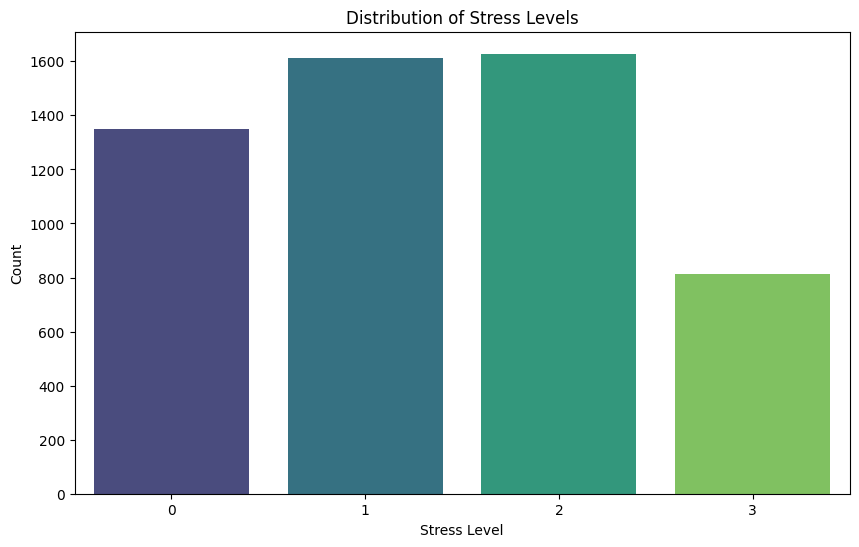

In [196]:
plt.figure(figsize=(10, 6))
sns.countplot(x='stress_level', data=df, palette='viridis')
plt.title('Distribution of Stress Levels')
plt.xlabel('Stress Level')
plt.ylabel('Count')
plt.show()

In [197]:
df.to_csv('./data/aggregate_data.csv', index=False)

In [198]:
df.columns

Index(['timestamp', 'trial', 'experimenter', 'heart_rate', 'BrightnessEV_max',
       'BrightnessEV_min', 'BrightnessEV_median', 'BrightnessEV_mean',
       'BrightnessEV_std', 'Peak-Frequency_max',
       ...
       'Inclination (deg)_min_lowpass_temp_mean_ws_10',
       'Inclination (deg)_median_lowpass_temp_mean_ws_10',
       'Inclination (deg)_mean_lowpass_temp_mean_ws_10',
       'Inclination (deg)_std_lowpass_temp_mean_ws_10',
       'Rotation (deg)_max_lowpass_temp_mean_ws_10',
       'Rotation (deg)_min_lowpass_temp_mean_ws_10',
       'Rotation (deg)_median_lowpass_temp_mean_ws_10',
       'Rotation (deg)_mean_lowpass_temp_mean_ws_10',
       'Rotation (deg)_std_lowpass_temp_mean_ws_10', 'stress_level'],
      dtype='object', length=141)

# Clustering (Undone)

In [ ]:
import math
import numbers
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import sys
from sklearn.neighbors import DistanceMetric
import sklearn



# Class defining the distance metrics that are not available as standard ones....
class InstanceDistanceMetrics:

    # S for gowers distance
    def s(self, val1, val2, range):
        # If we compare numbers we look at the difference and normalize.
        if isinstance(val1, numbers.Number) and isinstance(val1, numbers.Number):
            return 1 - (float(abs(val1-val2))/range)
        # If we compare something else, we just look at whether they are equal.
        else:
            if val1 == val2:
                return 1
            else:
                return 0

    # Delta for gowers distance.
    def delta(self, val1, val2):
        # Check whether both values are known (i.e. nan), if so the delta is 1, 0 otherwise.
        if (not np.isnan(val1)) and (not np.isnan(val2)):
            return 1
        return 0

    # Define gowers distance between two rows, given the ranges of the variables
    # over the entire dataset (over all columns in row1 and row2)
    def gowers_similarity(self, data_row1, data_row2, ranges):
        # We cannot computer if the lengths are not equal.
        if len(data_row1.columns) != len(data_row2.columns):
            return -1

        delta_total = 0
        s_total = 0

        # iterate over all columns.
        for i in range(0, len(data_row1.columns)):
            val1 = data_row1[data_row1.columns[i]].values[0]
            val2 = data_row2[data_row2.columns[i]].values[0]
            # compute the delta
            delta = self.delta(val1, val2)
            delta_total = delta_total + delta
            if delta > 0:
                # and compute the s if the delta is above 0.
                s_total = s_total + self.s(val1, val2, ranges[i])
        return float(s_total)/delta_total

# Class to flatten datasets or compute the statistical difference between cases.
class PersonDistanceMetricsNoOrdering:

    gower = 'gower'
    minkowski = 'minkowski'

    # This returns a dataset with aggregated data instances based on the mean values
    # in the rows.
    def create_instances_mean(self, datasets):
        index = range(0, len(datasets))
        cols = datasets[0].columns
        new_dataset = pd.DataFrame(index=index, columns=cols)

        for i in range(0, len(datasets)):
            for col in cols:
                # Compute the mean per column and assign that
                # value for the row representing the current
                # dataset.
                new_dataset.iloc[i, new_dataset.columns.get_loc(col)] = datasets[i][col].mean()

        return new_dataset

    # Fit datasets to normal distribution and use parameters as instances
    def create_instances_normal_distribution(self, datasets):
        index = range(0, len(datasets))
        cols = datasets[0].columns
        new_cols = []
        # Create new columns for the parameters of the distribution.
        for col in cols:
            new_cols.append(col + '_mu')
            new_cols.append(col + '_sigma')
        new_dataset = pd.DataFrame(index=index, columns=new_cols)

        for i in range(0, len(datasets)):
            for col in cols:
                # Fit the distribution and assign the values to the
                # row representing the dataset.
                mu, sigma = norm.fit(datasets[i][col])
                new_dataset.iloc[i, new_dataset.columns.get_loc(col + '_mu')] = mu
                new_dataset.iloc[i, new_dataset.columns.get_loc(col + '_sigma')] = sigma

        return new_dataset

    # This defines the distance between datasets based on the statistical
    # differences between the distribution we can only compute
    # distances pairwise.
    def p_distance(self, dataset1, dataset2):

        cols = dataset1.columns
        distance = 0
        for col in cols:
            D, p_value = stats.ks_2samp(dataset1[col], dataset2[col])
            distance= distance + (1-p_value)
        return distance

# Class to compare two time ordered datasets.
class PersonDistanceMetricsOrdering:

    extreme_value = sys.float_info.max
    tiny_value = 0.000001

    # Directly pair up the datasets and computer the euclidean
    # distances between the sequences of values.
    def euclidean_distance(self, dataset1, dataset2):
        dist = DistanceMetric.get_metric('euclidean')
        if not len(dataset1.index) == len(dataset2.index):
            return -1
        distance = 0

        for i in range(0, len(dataset1.index)):
            data_row1 = dataset1.iloc[:,i:i+1].transpose()
            data_row2 = dataset2.iloc[:,i:i+1].transpose()
            ecl_dist = dist.pairwise(data_row1, data_row2)
            distance = distance + ecl_dist

        return distance

    # Compute the distance between two datasets given a set lag.
    def lag_correlation_given_lag(self, dataset1, dataset2, lag):
        distance = 0
        for i in range(0, len(dataset1.columns)):
            # consider the lengths of the series, and compare the
            # number of points in the smallest series.
            length_ds1 = len(dataset1.index)
            length_ds2 = len(dataset2.index) - lag
            length_used = min(length_ds1, length_ds2)
            if length_used < 1:
                return self.extreme_value
            # We multiply the values as expressed in the book.
            ccc = np.multiply(dataset1.ix[0:length_used, i].values, dataset2.ix[lag:length_used+lag, i].values)
            # We add the sum of the mutliplications to the distance. Correct for the difference in length.
            distance = distance + (float(1)/(float(max(ccc.sum(), self.tiny_value))))/length_used
        return distance

    # Compute the lag correlation. For this we find the best lag.
    def lag_correlation(self, dataset1, dataset2, max_lag):
        best_dist = -1
        best_lag = 0
        for i in range(0, max_lag+1):
            # Compute the distance given a lag.
            current_dist = self.lag_correlation_given_lag(dataset1, dataset2, i)
            if current_dist < best_dist or best_dist == -1:
                best_dist = current_dist
                best_lag = i
        return best_dist

    # Simple implementation of the dtw. Note that we use the euclidean distance here..
    # The implementation follows the algorithm explained in the book very closely.
    def dynamic_time_warping(self, dataset1, dataset2):
        # Create a distance matrix between all time points.
        cheapest_path = np.full((len(dataset1.index), len(dataset2.index)), self.extreme_value)
        cheapest_path[0,0] = 0
        DM = InstanceDistanceMetrics()


        for i in range(1, len(dataset1.index)):
            for j in range(1, len(dataset2.index)):
                data_row1 = dataset1.iloc[i:i+1,:]
                data_row2 = dataset2.iloc[j:j+1,:]
                d = sklearn.metrics.pairwise.euclidean_distances(data_row1, data_row2)
                cheapest_path[i,j] = d + min(cheapest_path[i-1, j], cheapest_path[i, j-1], cheapest_path[i-1, j-1])
        return cheapest_path[len(dataset1.index)-1, len(dataset2.index)-1]

In [ ]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 5                                               #
#                                                            #
##############################################################

from sklearn.cluster import KMeans
import sklearn
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
import random
import scipy
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.neighbors import DistanceMetric
import pyclust

from nltk.cluster.kmeans import KMeansClusterer

# Implementation of the non hierarchical clustering approaches.
class NonHierarchicalClustering:

    # Global parameters for distance functions
    p = 1
    max_lag = 1

    # Identifiers of the various distance and abstraction approaches.
    euclidean = 'euclidean'
    minkowski = 'minkowski'
    manhattan = 'manhattan'
    gower = 'gower'
    abstraction_mean = 'abstraction_mean'
    abstraction_normal = 'abstraction_normal'
    abstraction_p = 'abstraction_p'
    abstraction_euclidean = 'abstract_euclidean'
    abstraction_lag = 'abstract_lag'
    abstraction_dtw = 'abstract_dtw'

    # Define the gowers distance between arrays to be used in k-means and k-medoids.
    def gowers_similarity(self, X, Y=None, Y_norm_squared=None, squared=False):
        X = np.matrix(X)
        distances = np.zeros(shape=(X.shape[0], Y.shape[0]))
        DM = InstanceDistanceMetrics()
        # Pairs up the elements in the dataset
        for x_row in range(0, X.shape[0]):
            data_row1 = pd.DataFrame(X[x_row])
            for y_row in range(0, Y.shape[0]):
                data_row2 = pd.DataFrame(Y[y_row]).transpose()
                # And computer the distance as defined in our distance metrics class.
                distances[x_row, y_row] = DM.gowers_similarity(data_row1, data_row2, self.p)
        return np.array(distances)

    # Use a predefined distance function for the Minkowski distance
    def minkowski_distance(self, X, Y=None, Y_norm_squared=None, squared=False):
        dist = DistanceMetric.get_metric('minkowski', p=self.p)
        return dist.pairwise(X, Y)

    # Use a predefined distance function for the Manhattan distance
    def manhattan_distance(self, X, Y=None, Y_norm_squared=None, squared=False):
        dist = DistanceMetric.get_metric('manhattan')
        return dist.pairwise(X, Y)

    # Use a predefined distance function for the Euclidean distance
    def euclidean_distance(self, X, Y=None, Y_norm_squared=None, squared=False):
        dist = DistanceMetric.get_metric('euclidean')
        return dist.pairwise(X, Y)

    # If we want to compare dataset between persons one approach is to flatten
    # each dataset to a single record/instance. This is done based on the approaches
    # we have defined in the distance metrics file.
    def aggregate_datasets(self, datasets, cols, abstraction_method):
        temp_datasets = []
        DM = PersonDistanceMetricsNoOrdering()

        # Flatten all datasets and add them to the newly formed dataset.
        for i in range(0, len(datasets)):
            temp_dataset = datasets[i][cols]
            temp_datasets.append(temp_dataset)

        if abstraction_method == self.abstraction_normal:
            return DM.create_instances_normal_distribution(temp_datasets)
        else:
            return DM.create_instances_mean(temp_datasets)

    # Perform k-means over an individual dataset.
    def k_means_over_instances(self, dataset, cols, k, distance_metric, max_iters, n_inits, p=1):

        # Take the appropriate columns.
        temp_dataset = dataset[cols]
        # Override the standard distance functions. Store the original first
        # sklearn_euclidian_distances = sklearn.cluster.k_means_.euclidean_distances
        sklearn_euclidian_distances = sklearn.metrics.pairwise.euclidean_distances
        if distance_metric == self.euclidean:
            sklearn.metrics.pairwise.euclidean_distances = self.euclidean_distance
        elif distance_metric == self.minkowski:
            self.p = p
            sklearn.metrics.pairwise.euclidean_distances = self.minkowski_distance
        elif distance_metric == self.manhattan:
            sklearn.metrics.pairwise.euclidean_distances = self.manhattan_distance
        elif distance_metric == self.gower:
            self.ranges = []
            for col in temp_dataset.columns:
                self.ranges.append(temp_dataset[col].max() - temp_dataset[col].min())
            sklearn.metrics.pairwise.euclidean_distances = self.gowers_similarity
        # If we do not recognize the option we use the default distance function, which is much
        # faster....
        # Now apply the k-means algorithm
        kmeans = KMeans(n_clusters=k, max_iter=max_iters, n_init=n_inits, random_state=0).fit(temp_dataset)
        # Add the labels to the dataset
        dataset['cluster'] = kmeans.labels_
        # Compute the solhouette and add it as well.
        silhouette_avg = silhouette_score(temp_dataset, kmeans.labels_)
        silhouette_per_inst = silhouette_samples(temp_dataset, kmeans.labels_)
        dataset['silhouette'] = silhouette_per_inst

        # Reset the module distance function for further usage
        sklearn_euclidian_distances = sklearn_euclidian_distances

        return dataset

    # We have datasets covering multiple persons. We abstract the datatasets using an approach and create
    # clusters of persons.
    def k_means_over_datasets(self, datasets, cols, k, abstraction_method, distance_metric, max_iters, n_inits, p=1):
        # Convert the datasets to instances
        temp_dataset = self.aggregate_datasets(datasets, cols, abstraction_method)

        # And simply apply the instance based algorithm.....
        return self.k_means_over_instances(temp_dataset, temp_dataset.columns, k, distance_metric, max_iters, n_inits, p)

    # For our own k-medoids algorithm we use our own implementation. For this we computer a complete distance matrix
    # between points.
    def compute_distance_matrix_instances(self, dataset, distance_metric):
        # If the distance function is not defined in our distance metrics, we use the standard euclidean distance.
        if not (distance_metric in [self.manhattan, self.minkowski, self.gower, self.euclidean]):
            distances = sklearn.metrics.pairwise.euclidean_distances(X=dataset, Y=dataset)
            return pd.DataFrame(distances, index=range(0, len(dataset.index)), columns=range(0, len(dataset.index)))
        # Create an empty pandas dataframe for our distance matrix
        distances = pd.DataFrame(index=range(0, len(dataset.index)), columns=range(0, len(dataset.index)))
        DM = InstanceDistanceMetrics()

        # Define the ranges of the columns if we use the gower distance.
        ranges = []
        if distance_metric == self.gower:
            for col in dataset.columns:
                self.ranges.append(dataset[col].max() - dataset[col].min())

        # And compute the distances for each pair. Note that we assume the distances to be symmetric.
        for i in range(0, len(dataset.index)):
            for j in range(i, len(dataset.index)):
                if distance_metric == self.manhattan:
                    distances.iloc[i,j] = self.manhattan_distance(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:])
                elif distance_metric == self.minkowski:
                    distances.iloc[i,j] = self.manhattan_distance(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:], self.p)
                elif distance_metric == self.gower:
                    distances.iloc[i,j] = self.gowers_similarity(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:])
                elif distance_metric == self.euclidean:
                    distances.iloc[i,j] = self.euclidean_distance(dataset.iloc[i:i+1,:], dataset.iloc[j:j+1,:])
                distances.iloc[j,i] = distances.iloc[i,j]
        return distances

    # We need to implement k-medoids ourselves to accommodate all distance metrics
    def k_medoids_over_instances(self, dataset, cols, k, distance_metric, max_iters, n_inits=5, p=1):
        # If we set it to default we use the pyclust package...
        temp_dataset = dataset[cols]
        if distance_metric == 'default':
            km = pyclust.KMedoids(n_clusters=k, n_trials=n_inits)
            km.fit(temp_dataset.values)
            cluster_assignment = km.labels_

        else:
            print("It workds")
            self.p = p
            cluster_assignment = []
            best_silhouette = -1

            # Compute all distances
            D = self.compute_distance_matrix_instances(temp_dataset, distance_metric)

            for it in range(0, n_inits):
                # First select k random points as centers:
                centers = random.sample(range(0, len(dataset.index)), k)
                prev_centers = []
                points_to_cluster = []

                n_iter = 0
                while (n_iter < max_iters) and not (centers == prev_centers):
                    n_iter += 1
                    prev_centers = centers
                    # Assign points to clusters.
                    points_to_centroid = D[centers].idxmin(axis=1)

                    new_centers = []
                    for i in range(0, k):
                    # And find the new center that minimized the sum of the differences.
                      
                        best_center = D.loc[points_to_centroid == centers[i]].sum().idxmin(axis=1)
                        new_centers.append(best_center)
                    centers = new_centers

                # Convert centroids to cluster numbers:

                points_to_centroid = D[centers].idxmin(axis=1)
                current_cluster_assignment = []
                for i in range(0, len(dataset.index)):
                    current_cluster_assignment.append(centers.index(points_to_centroid.iloc[i]))

                silhouette_avg = silhouette_score(temp_dataset, np.array(current_cluster_assignment))
                if silhouette_avg > best_silhouette:
                    cluster_assignment = current_cluster_assignment
                    best_silhouette = silhouette_avg

        # And add the clusters and silhouette scores to the dataset.
        dataset['cluster'] = cluster_assignment
        silhouette_avg = silhouette_score(temp_dataset, np.array(cluster_assignment))
        silhouette_per_inst = silhouette_samples(temp_dataset, np.array(cluster_assignment))
        dataset['silhouette'] = silhouette_per_inst

        return dataset

    # For k-medoids we use all possible distance metrics between datasets as well. For this we
    # again need to define a distance matrix between the datasets.
    def compute_distance_matrix_datasets(self, datasets, distance_metric):
        distances = pd.DataFrame(index=range(0, len(datasets)), columns=range(0, len(datasets)))
        DMNoOrdering = PersonDistanceMetricsNoOrdering()
        DMOrdering = PersonDistanceMetricsOrdering()

        # And compute the distances for each pair. Note that we assume the distances to be symmetric.
        for i in range(0, len(datasets)):
            for j in range(i, len(datasets)):
                if distance_metric == self.abstraction_p:
                    distances.iloc[i,j] = DMNoOrdering.p_distance(datasets[i], datasets[j])
                elif distance_metric == self.abstraction_euclidean:
                    distances.iloc[i,j] = DMOrdering.euclidean_distance(datasets[i], datasets[j])
                elif distance_metric == self.abstraction_lag:
                    distances.iloc[i,j] = DMOrdering.lag_correlation(datasets[i], datasets[j], self.max_lag)
                elif distance_metric == self.abstraction_dtw:
                    distances.iloc[i,j] = DMOrdering.dynamic_time_warping(datasets[i], datasets[j])
                distances.iloc[j,i] = distances.iloc[i,j]
        return distances

    # Note: distance metric only important in combination with certain abstraction methods as we allow for more
    # in k-medoids.
    def k_medoids_over_datasets(self, datasets, cols, k, abstraction_method, distance_metric, max_iters, n_inits=5, p=1, max_lag=5):
        self.p = p
        self.max_lag = max_lag

        # If we compare datasets by flattening them, we can simply flatten the dataset and apply the instance based
        # variant.
        if abstraction_method in [self.abstraction_mean, self.abstraction_normal]:
            # Convert the datasets to instances
            temp_dataset = self.aggregate_datasets(datasets, cols, abstraction_method)

            # And simply apply the instance based algorithm in case of
            return self.k_medoids_over_instances(temp_dataset, temp_dataset.columns, k, distance_metric, max_iters, n_inits=n_inits, p=p)

        # For the case over datasets we do not have a quality metric, therefore we just look at a single initialization for now (!)

        # First select k random points as centers:
        centers = random.sample(range(0, len(datasets)), k)
        prev_centers = []
        points_to_cluster = []
        # Compute all distances
        D = self.compute_distance_matrix_datasets(datasets, abstraction_method)

        n_iter = 0
        while (n_iter < max_iters) and not (centers == prev_centers):
            n_iter += 1
            prev_centers = centers
            # Assign points to clusters.
            points_to_centroid = D[centers].idxmin(axis=1)

            new_centers = []
            for i in range(0, k):
                # And find the new center that minimized the sum of the differences.
                best_center = D.loc[points_to_centroid == centers[i], points_to_centroid == centers[i]].sum().idxmin(axis=1)
                new_centers.append(best_center)
            centers = new_centers

        # Convert centroids to cluster numbers:

        points_to_centroid = D[centers].idxmin(axis=1)
        cluster_assignment = []
        for i in range(0, len(datasets)):
            cluster_assignment.append(centers.index(points_to_centroid.iloc[i,:]))

        dataset = pd.DataFrame(index=range(0, len(datasets)))
        dataset['cluster'] = cluster_assignment

        # Silhouette cannot be used here as it used a distance between instances, not datasets.

        return dataset

In [ ]:
clustering = NonHierarchicalClustering()

In [ ]:
clustering.k_medoids_over_datasets(df, ['BrightnessEV_mean'], 10, 'abstraction_mean', 'euclidean', 10)